# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

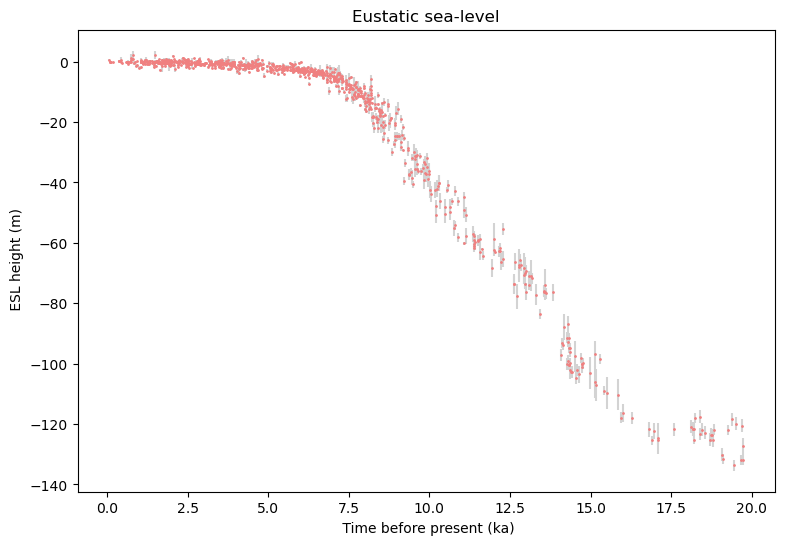

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

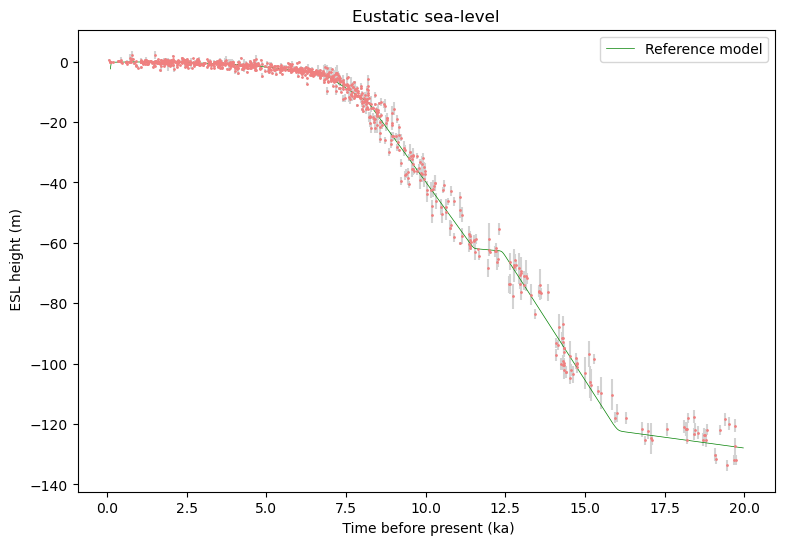

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'sampling', 'optimization', 'matrix solvers'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.linalg.lstsq (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

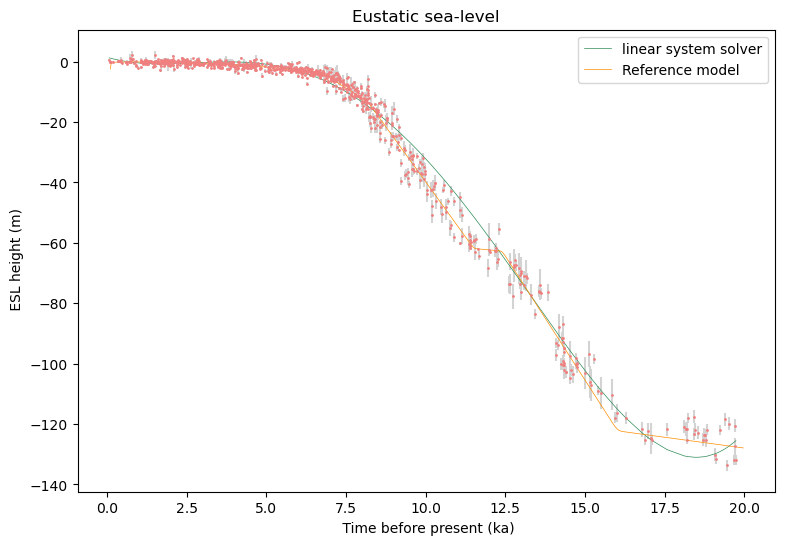

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]

Summary for inversion result
FAILURE
----------------------------
fun: 396.30180936007037
nit: 598
nfev: 1000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 4.02211771, -7.6352002 ,  3.47983694, -0.52237961,  0.02043681],
       [ 4.02227491, -7.63498804,  3.47977907, -0.52238912,  0.02043829],
       [ 4.02218792, -7.63507241,  3.47979137, -0.5223722 ,  0.02043577],
       [ 4.02245903, -7.63488993,  3.47966829, -0.52235893,  0.02043602],
       [ 4.02257488, -7.63525136,  3.47962954, -0.52233062,  0.02043424],
       [ 4.02215782, -7.63502984,  3.47981924, -0.5223883 ,  0.02043736]]), array([396.30180936, 396.30181593, 396.30181983, 396.30182837,
       396.30183836, 396.30184074]))
model: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]


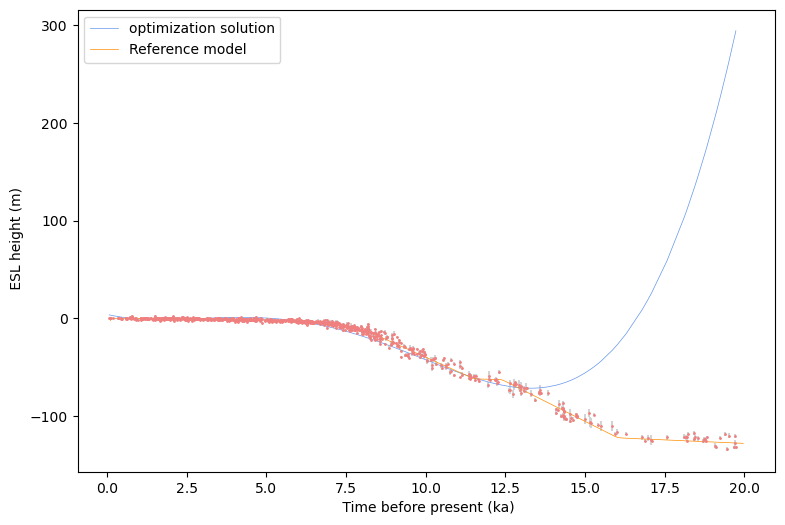

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


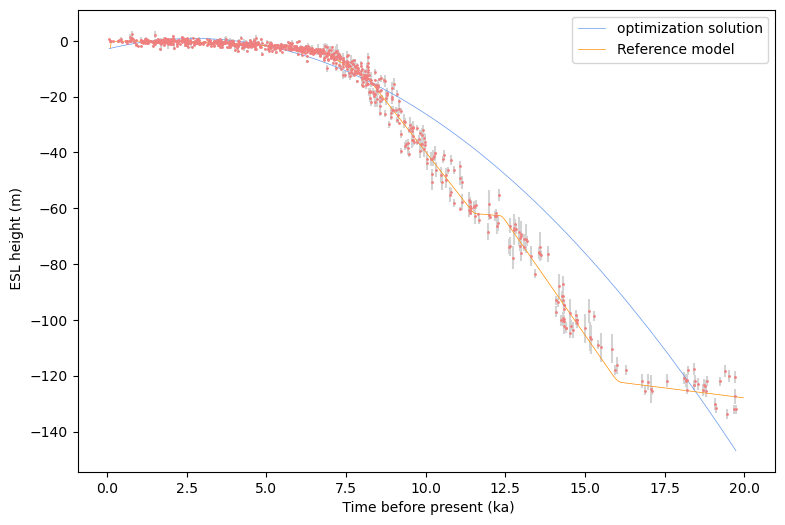

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                                            | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                   | 9/10000 [00:00<02:02, 81.83it/s]

  0%|▎                                                                                                                                                                  | 18/10000 [00:00<02:26, 68.33it/s]

  0%|▍                                                                                                                                                                  | 27/10000 [00:00<02:12, 75.48it/s]

  0%|▋                                                                                                                                                                  | 41/10000 [00:00<01:43, 96.44it/s]

  1%|▊                                                                                                                                                                  | 51/10000 [00:00<01:50, 89.93it/s]

  1%|▉                                                                                                                                                                  | 61/10000 [00:00<01:47, 92.34it/s]

  1%|█▏                                                                                                                                                                 | 71/10000 [00:00<01:47, 92.66it/s]

  1%|█▎                                                                                                                                                                 | 81/10000 [00:00<01:58, 83.94it/s]

  1%|█▍                                                                                                                                                                 | 90/10000 [00:01<01:58, 83.38it/s]

  1%|█▋                                                                                                                                                                | 103/10000 [00:01<01:44, 94.46it/s]

  1%|█▊                                                                                                                                                                | 113/10000 [00:01<01:53, 87.47it/s]

  1%|██                                                                                                                                                               | 127/10000 [00:01<01:38, 100.72it/s]

  1%|██▏                                                                                                                                                              | 138/10000 [00:01<01:38, 100.63it/s]

  1%|██▍                                                                                                                                                               | 149/10000 [00:01<01:42, 96.49it/s]

  2%|██▌                                                                                                                                                              | 163/10000 [00:01<01:31, 107.51it/s]

  2%|██▊                                                                                                                                                               | 174/10000 [00:01<01:38, 99.38it/s]

  2%|███                                                                                                                                                              | 187/10000 [00:01<01:31, 106.95it/s]

  2%|███▏                                                                                                                                                             | 201/10000 [00:02<01:24, 115.37it/s]

  2%|███▍                                                                                                                                                             | 215/10000 [00:02<01:20, 120.81it/s]

  2%|███▋                                                                                                                                                             | 229/10000 [00:02<01:18, 125.22it/s]

  2%|███▉                                                                                                                                                             | 243/10000 [00:02<01:15, 128.78it/s]

  3%|████▏                                                                                                                                                            | 257/10000 [00:02<01:14, 131.36it/s]

  3%|████▎                                                                                                                                                            | 271/10000 [00:02<01:13, 133.23it/s]

  3%|████▌                                                                                                                                                            | 285/10000 [00:02<01:12, 134.74it/s]

  3%|████▊                                                                                                                                                            | 299/10000 [00:02<01:11, 136.05it/s]

  3%|█████                                                                                                                                                            | 313/10000 [00:02<01:10, 136.96it/s]

  3%|█████▎                                                                                                                                                           | 327/10000 [00:02<01:10, 136.61it/s]

  3%|█████▍                                                                                                                                                           | 341/10000 [00:03<01:10, 137.29it/s]

  4%|█████▋                                                                                                                                                           | 355/10000 [00:03<01:11, 134.70it/s]

  4%|█████▉                                                                                                                                                           | 369/10000 [00:03<01:11, 135.01it/s]

  4%|██████▏                                                                                                                                                          | 383/10000 [00:03<01:11, 135.36it/s]

  4%|██████▍                                                                                                                                                          | 397/10000 [00:03<01:10, 135.69it/s]

  4%|██████▌                                                                                                                                                          | 411/10000 [00:03<01:10, 136.04it/s]

  4%|██████▊                                                                                                                                                          | 425/10000 [00:03<01:10, 136.24it/s]

  4%|███████                                                                                                                                                          | 439/10000 [00:03<01:10, 136.19it/s]

  5%|███████▎                                                                                                                                                         | 453/10000 [00:03<01:09, 136.52it/s]

  5%|███████▌                                                                                                                                                         | 467/10000 [00:04<01:09, 137.11it/s]

  5%|███████▋                                                                                                                                                         | 481/10000 [00:04<01:09, 137.68it/s]

  5%|███████▉                                                                                                                                                         | 495/10000 [00:04<01:08, 138.06it/s]

  5%|████████▏                                                                                                                                                        | 509/10000 [00:04<01:08, 137.86it/s]

  5%|████████▍                                                                                                                                                        | 523/10000 [00:04<01:08, 138.28it/s]

  5%|████████▋                                                                                                                                                        | 537/10000 [00:04<01:08, 138.27it/s]

  6%|████████▊                                                                                                                                                        | 551/10000 [00:04<01:08, 138.36it/s]

  6%|█████████                                                                                                                                                        | 565/10000 [00:04<01:08, 138.25it/s]

  6%|█████████▎                                                                                                                                                       | 579/10000 [00:04<01:23, 113.15it/s]

  6%|█████████▌                                                                                                                                                       | 593/10000 [00:05<01:18, 119.31it/s]

  6%|█████████▊                                                                                                                                                       | 607/10000 [00:05<01:15, 124.63it/s]

  6%|█████████▉                                                                                                                                                       | 621/10000 [00:05<01:13, 128.24it/s]

  6%|██████████▏                                                                                                                                                      | 635/10000 [00:05<01:11, 130.87it/s]

  6%|██████████▍                                                                                                                                                      | 649/10000 [00:05<01:10, 133.09it/s]

  7%|██████████▋                                                                                                                                                      | 663/10000 [00:05<01:09, 134.84it/s]

  7%|██████████▉                                                                                                                                                      | 677/10000 [00:05<01:08, 135.69it/s]

  7%|███████████▏                                                                                                                                                     | 691/10000 [00:05<01:08, 135.59it/s]

  7%|███████████▎                                                                                                                                                     | 705/10000 [00:05<01:18, 118.69it/s]

  7%|███████████▌                                                                                                                                                     | 719/10000 [00:05<01:14, 124.07it/s]

  7%|███████████▊                                                                                                                                                     | 733/10000 [00:06<01:12, 128.43it/s]

  7%|████████████                                                                                                                                                     | 747/10000 [00:06<01:10, 131.44it/s]

  8%|████████████▎                                                                                                                                                    | 761/10000 [00:06<01:09, 133.74it/s]

  8%|████████████▍                                                                                                                                                    | 776/10000 [00:06<01:07, 135.71it/s]

  8%|████████████▋                                                                                                                                                    | 790/10000 [00:06<01:07, 136.93it/s]

  8%|████████████▉                                                                                                                                                    | 805/10000 [00:06<01:06, 137.91it/s]

  8%|█████████████▏                                                                                                                                                   | 819/10000 [00:06<01:06, 138.38it/s]

  8%|█████████████▍                                                                                                                                                   | 833/10000 [00:06<01:06, 138.83it/s]

  8%|█████████████▋                                                                                                                                                   | 847/10000 [00:06<01:09, 131.66it/s]

  9%|█████████████▊                                                                                                                                                   | 861/10000 [00:07<01:10, 129.76it/s]

  9%|██████████████                                                                                                                                                   | 875/10000 [00:07<01:08, 132.60it/s]

  9%|██████████████▎                                                                                                                                                  | 889/10000 [00:07<01:08, 132.57it/s]

  9%|██████████████▌                                                                                                                                                  | 903/10000 [00:07<01:07, 134.17it/s]

  9%|██████████████▊                                                                                                                                                  | 917/10000 [00:07<01:14, 122.42it/s]

  9%|██████████████▉                                                                                                                                                  | 931/10000 [00:07<01:11, 127.07it/s]

  9%|███████████████▏                                                                                                                                                 | 945/10000 [00:07<01:09, 130.64it/s]

 10%|███████████████▍                                                                                                                                                 | 959/10000 [00:07<01:07, 133.29it/s]

 10%|███████████████▋                                                                                                                                                 | 973/10000 [00:07<01:06, 135.22it/s]

 10%|███████████████▉                                                                                                                                                 | 987/10000 [00:07<01:05, 136.56it/s]

 10%|████████████████                                                                                                                                                | 1002/10000 [00:08<01:05, 137.67it/s]

 10%|████████████████▎                                                                                                                                               | 1016/10000 [00:08<01:05, 137.04it/s]

 10%|████████████████▍                                                                                                                                               | 1030/10000 [00:08<01:05, 137.31it/s]

 10%|████████████████▋                                                                                                                                               | 1044/10000 [00:08<01:11, 125.96it/s]

 11%|████████████████▉                                                                                                                                               | 1058/10000 [00:08<01:08, 129.72it/s]

 11%|█████████████████▏                                                                                                                                              | 1073/10000 [00:08<01:07, 132.82it/s]

 11%|█████████████████▍                                                                                                                                              | 1087/10000 [00:08<01:06, 134.85it/s]

 11%|█████████████████▌                                                                                                                                              | 1101/10000 [00:08<01:05, 136.26it/s]

 11%|█████████████████▊                                                                                                                                              | 1115/10000 [00:08<01:04, 136.87it/s]

 11%|██████████████████                                                                                                                                              | 1129/10000 [00:09<01:04, 137.50it/s]

 11%|██████████████████▎                                                                                                                                             | 1143/10000 [00:09<01:04, 138.16it/s]

 12%|██████████████████▌                                                                                                                                             | 1157/10000 [00:09<01:03, 138.65it/s]

 12%|██████████████████▋                                                                                                                                             | 1171/10000 [00:09<01:03, 138.99it/s]

 12%|██████████████████▉                                                                                                                                             | 1185/10000 [00:09<01:03, 139.06it/s]

 12%|███████████████████▏                                                                                                                                            | 1199/10000 [00:09<01:03, 139.23it/s]

 12%|███████████████████▍                                                                                                                                            | 1214/10000 [00:09<01:02, 139.51it/s]

 12%|███████████████████▋                                                                                                                                            | 1229/10000 [00:09<01:02, 139.70it/s]

 12%|███████████████████▉                                                                                                                                            | 1244/10000 [00:09<01:02, 139.88it/s]

 13%|████████████████████▏                                                                                                                                           | 1258/10000 [00:09<01:02, 139.09it/s]

 13%|████████████████████▎                                                                                                                                           | 1272/10000 [00:10<01:07, 129.34it/s]

 13%|████████████████████▌                                                                                                                                           | 1286/10000 [00:10<01:06, 131.49it/s]

 13%|████████████████████▊                                                                                                                                           | 1300/10000 [00:10<01:05, 133.66it/s]

 13%|█████████████████████                                                                                                                                           | 1315/10000 [00:10<01:04, 135.65it/s]

 13%|█████████████████████▎                                                                                                                                          | 1330/10000 [00:10<01:03, 137.04it/s]

 13%|█████████████████████▌                                                                                                                                          | 1344/10000 [00:10<01:02, 137.85it/s]

 14%|█████████████████████▋                                                                                                                                          | 1359/10000 [00:10<01:02, 138.58it/s]

 14%|█████████████████████▉                                                                                                                                          | 1373/10000 [00:10<01:02, 138.01it/s]

 14%|██████████████████████▏                                                                                                                                         | 1388/10000 [00:10<01:02, 138.65it/s]

 14%|██████████████████████▍                                                                                                                                         | 1402/10000 [00:11<01:10, 121.24it/s]

 14%|██████████████████████▋                                                                                                                                         | 1416/10000 [00:11<01:08, 126.16it/s]

 14%|██████████████████████▉                                                                                                                                         | 1431/10000 [00:11<01:05, 130.23it/s]

 14%|███████████████████████▏                                                                                                                                        | 1446/10000 [00:11<01:04, 133.13it/s]

 15%|███████████████████████▍                                                                                                                                        | 1461/10000 [00:11<01:03, 135.21it/s]

 15%|███████████████████████▌                                                                                                                                        | 1476/10000 [00:11<01:02, 136.70it/s]

 15%|███████████████████████▊                                                                                                                                        | 1491/10000 [00:11<01:01, 137.74it/s]

 15%|████████████████████████                                                                                                                                        | 1505/10000 [00:11<01:01, 138.37it/s]

 15%|████████████████████████▎                                                                                                                                       | 1520/10000 [00:11<01:01, 138.93it/s]

 15%|████████████████████████▌                                                                                                                                       | 1534/10000 [00:11<01:00, 139.19it/s]

 15%|████████████████████████▊                                                                                                                                       | 1548/10000 [00:12<01:01, 138.24it/s]

 16%|████████████████████████▉                                                                                                                                       | 1562/10000 [00:12<01:01, 137.86it/s]

 16%|█████████████████████████▏                                                                                                                                      | 1576/10000 [00:12<01:00, 138.46it/s]

 16%|█████████████████████████▍                                                                                                                                      | 1591/10000 [00:12<01:00, 139.00it/s]

 16%|█████████████████████████▋                                                                                                                                      | 1605/10000 [00:12<01:00, 139.29it/s]

 16%|█████████████████████████▉                                                                                                                                      | 1620/10000 [00:12<01:00, 139.60it/s]

 16%|██████████████████████████▏                                                                                                                                     | 1634/10000 [00:12<01:01, 135.38it/s]

 16%|██████████████████████████▍                                                                                                                                     | 1649/10000 [00:12<01:01, 136.84it/s]

 17%|██████████████████████████▌                                                                                                                                     | 1664/10000 [00:12<01:00, 137.81it/s]

 17%|██████████████████████████▊                                                                                                                                     | 1678/10000 [00:13<01:00, 138.43it/s]

 17%|███████████████████████████                                                                                                                                     | 1693/10000 [00:13<00:59, 138.97it/s]

 17%|███████████████████████████▎                                                                                                                                    | 1708/10000 [00:13<00:59, 139.39it/s]

 17%|███████████████████████████▌                                                                                                                                    | 1723/10000 [00:13<00:59, 139.73it/s]

 17%|███████████████████████████▊                                                                                                                                    | 1737/10000 [00:13<00:59, 139.76it/s]

 18%|████████████████████████████                                                                                                                                    | 1752/10000 [00:13<00:58, 139.99it/s]

 18%|████████████████████████████▎                                                                                                                                   | 1767/10000 [00:13<00:58, 140.10it/s]

 18%|████████████████████████████▌                                                                                                                                   | 1782/10000 [00:13<00:58, 140.26it/s]

 18%|████████████████████████████▊                                                                                                                                   | 1797/10000 [00:13<00:58, 140.37it/s]

 18%|████████████████████████████▉                                                                                                                                   | 1812/10000 [00:14<01:05, 125.60it/s]

 18%|█████████████████████████████▏                                                                                                                                  | 1826/10000 [00:14<01:03, 129.41it/s]

 18%|█████████████████████████████▍                                                                                                                                  | 1841/10000 [00:14<01:01, 132.54it/s]

 19%|█████████████████████████████▋                                                                                                                                  | 1856/10000 [00:14<01:00, 134.80it/s]

 19%|█████████████████████████████▉                                                                                                                                  | 1871/10000 [00:14<00:59, 136.41it/s]

 19%|██████████████████████████████▏                                                                                                                                 | 1886/10000 [00:14<00:58, 137.60it/s]

 19%|██████████████████████████████▍                                                                                                                                 | 1901/10000 [00:14<00:58, 138.27it/s]

 19%|██████████████████████████████▋                                                                                                                                 | 1915/10000 [00:14<00:58, 138.07it/s]

 19%|██████████████████████████████▊                                                                                                                                 | 1929/10000 [00:14<00:58, 138.41it/s]

 19%|███████████████████████████████                                                                                                                                 | 1944/10000 [00:14<00:57, 138.91it/s]

 20%|███████████████████████████████▎                                                                                                                                | 1958/10000 [00:15<00:58, 137.98it/s]

 20%|███████████████████████████████▌                                                                                                                                | 1972/10000 [00:15<00:58, 138.00it/s]

 20%|███████████████████████████████▊                                                                                                                                | 1987/10000 [00:15<00:57, 138.73it/s]

 20%|████████████████████████████████                                                                                                                                | 2002/10000 [00:15<00:57, 139.25it/s]

 20%|████████████████████████████████▎                                                                                                                               | 2017/10000 [00:15<00:57, 139.55it/s]

 20%|████████████████████████████████▍                                                                                                                               | 2031/10000 [00:15<00:57, 139.25it/s]

 20%|████████████████████████████████▋                                                                                                                               | 2046/10000 [00:15<00:57, 138.51it/s]

 21%|████████████████████████████████▉                                                                                                                               | 2060/10000 [00:15<00:57, 138.87it/s]

 21%|█████████████████████████████████▏                                                                                                                              | 2075/10000 [00:15<00:56, 139.37it/s]

 21%|█████████████████████████████████▍                                                                                                                              | 2089/10000 [00:16<00:56, 139.43it/s]

 21%|█████████████████████████████████▋                                                                                                                              | 2103/10000 [00:16<00:56, 139.59it/s]

 21%|█████████████████████████████████▉                                                                                                                              | 2118/10000 [00:16<00:56, 139.74it/s]

 21%|██████████████████████████████████                                                                                                                              | 2132/10000 [00:16<00:56, 139.81it/s]

 21%|██████████████████████████████████▎                                                                                                                             | 2146/10000 [00:16<00:56, 138.65it/s]

 22%|██████████████████████████████████▌                                                                                                                             | 2160/10000 [00:16<00:56, 138.93it/s]

 22%|██████████████████████████████████▊                                                                                                                             | 2175/10000 [00:16<00:56, 139.38it/s]

 22%|███████████████████████████████████                                                                                                                             | 2190/10000 [00:16<00:55, 139.64it/s]

 22%|███████████████████████████████████▎                                                                                                                            | 2204/10000 [00:16<00:55, 139.73it/s]

 22%|███████████████████████████████████▌                                                                                                                            | 2219/10000 [00:16<00:55, 139.84it/s]

 22%|███████████████████████████████████▋                                                                                                                            | 2233/10000 [00:17<00:55, 139.80it/s]

 22%|███████████████████████████████████▉                                                                                                                            | 2247/10000 [00:17<01:04, 121.10it/s]

 23%|████████████████████████████████████▏                                                                                                                           | 2260/10000 [00:17<01:09, 111.09it/s]

 23%|████████████████████████████████████▍                                                                                                                           | 2274/10000 [00:17<01:05, 118.36it/s]

 23%|████████████████████████████████████▌                                                                                                                           | 2288/10000 [00:17<01:04, 119.73it/s]

 23%|████████████████████████████████████▊                                                                                                                           | 2302/10000 [00:17<01:01, 125.13it/s]

 23%|█████████████████████████████████████                                                                                                                           | 2316/10000 [00:17<00:59, 129.22it/s]

 23%|█████████████████████████████████████▎                                                                                                                          | 2330/10000 [00:17<00:58, 132.20it/s]

 23%|█████████████████████████████████████▌                                                                                                                          | 2344/10000 [00:17<00:56, 134.33it/s]

 24%|█████████████████████████████████████▋                                                                                                                          | 2358/10000 [00:18<00:56, 135.80it/s]

 24%|█████████████████████████████████████▉                                                                                                                          | 2372/10000 [00:18<00:55, 136.65it/s]

 24%|██████████████████████████████████████▏                                                                                                                         | 2386/10000 [00:18<01:02, 121.60it/s]

 24%|██████████████████████████████████████▍                                                                                                                         | 2399/10000 [00:18<01:02, 122.17it/s]

 24%|██████████████████████████████████████▌                                                                                                                         | 2413/10000 [00:18<00:59, 127.00it/s]

 24%|██████████████████████████████████████▊                                                                                                                         | 2427/10000 [00:18<00:57, 130.60it/s]

 24%|███████████████████████████████████████                                                                                                                         | 2441/10000 [00:18<00:56, 133.27it/s]

 25%|███████████████████████████████████████▎                                                                                                                        | 2456/10000 [00:18<00:55, 135.35it/s]

 25%|███████████████████████████████████████▌                                                                                                                        | 2470/10000 [00:18<00:55, 136.66it/s]

 25%|███████████████████████████████████████▋                                                                                                                        | 2484/10000 [00:19<01:02, 119.89it/s]

 25%|███████████████████████████████████████▉                                                                                                                        | 2498/10000 [00:19<00:59, 125.06it/s]

 25%|████████████████████████████████████████▏                                                                                                                       | 2512/10000 [00:19<00:57, 129.11it/s]

 25%|████████████████████████████████████████▍                                                                                                                       | 2526/10000 [00:19<00:56, 132.08it/s]

 25%|████████████████████████████████████████▋                                                                                                                       | 2540/10000 [00:19<00:55, 133.96it/s]

 26%|████████████████████████████████████████▊                                                                                                                       | 2554/10000 [00:19<00:54, 135.56it/s]

 26%|█████████████████████████████████████████                                                                                                                       | 2568/10000 [00:19<00:54, 136.53it/s]

 26%|█████████████████████████████████████████▎                                                                                                                      | 2582/10000 [00:19<00:54, 136.96it/s]

 26%|█████████████████████████████████████████▌                                                                                                                      | 2596/10000 [00:19<00:53, 137.60it/s]

 26%|█████████████████████████████████████████▊                                                                                                                      | 2610/10000 [00:19<00:53, 138.13it/s]

 26%|█████████████████████████████████████████▉                                                                                                                      | 2624/10000 [00:20<00:53, 136.67it/s]

 26%|██████████████████████████████████████████▏                                                                                                                     | 2638/10000 [00:20<00:53, 137.37it/s]

 27%|██████████████████████████████████████████▍                                                                                                                     | 2652/10000 [00:20<00:53, 137.96it/s]

 27%|██████████████████████████████████████████▋                                                                                                                     | 2666/10000 [00:20<00:53, 138.16it/s]

 27%|██████████████████████████████████████████▉                                                                                                                     | 2680/10000 [00:20<00:52, 138.43it/s]

 27%|███████████████████████████████████████████                                                                                                                     | 2694/10000 [00:20<00:52, 138.63it/s]

 27%|███████████████████████████████████████████▎                                                                                                                    | 2708/10000 [00:20<00:52, 138.77it/s]

 27%|███████████████████████████████████████████▌                                                                                                                    | 2722/10000 [00:20<00:52, 137.59it/s]

 27%|███████████████████████████████████████████▊                                                                                                                    | 2736/10000 [00:20<00:52, 138.20it/s]

 28%|████████████████████████████████████████████                                                                                                                    | 2750/10000 [00:20<00:52, 138.11it/s]

 28%|████████████████████████████████████████████▏                                                                                                                   | 2764/10000 [00:21<00:52, 138.54it/s]

 28%|████████████████████████████████████████████▍                                                                                                                   | 2778/10000 [00:21<00:52, 138.85it/s]

 28%|████████████████████████████████████████████▋                                                                                                                   | 2792/10000 [00:21<00:51, 139.00it/s]

 28%|████████████████████████████████████████████▉                                                                                                                   | 2806/10000 [00:21<00:51, 139.14it/s]

 28%|█████████████████████████████████████████████                                                                                                                   | 2820/10000 [00:21<00:51, 139.29it/s]

 28%|█████████████████████████████████████████████▎                                                                                                                  | 2834/10000 [00:21<00:53, 133.47it/s]

 28%|█████████████████████████████████████████████▌                                                                                                                  | 2848/10000 [00:21<00:53, 133.04it/s]

 29%|█████████████████████████████████████████████▊                                                                                                                  | 2862/10000 [00:21<00:53, 134.45it/s]

 29%|██████████████████████████████████████████████                                                                                                                  | 2876/10000 [00:21<00:52, 135.96it/s]

 29%|██████████████████████████████████████████████▏                                                                                                                 | 2890/10000 [00:22<00:51, 136.83it/s]

 29%|██████████████████████████████████████████████▍                                                                                                                 | 2904/10000 [00:22<00:51, 136.93it/s]

 29%|██████████████████████████████████████████████▋                                                                                                                 | 2918/10000 [00:22<00:51, 137.66it/s]

 29%|██████████████████████████████████████████████▉                                                                                                                 | 2932/10000 [00:22<00:51, 138.20it/s]

 29%|███████████████████████████████████████████████▏                                                                                                                | 2946/10000 [00:22<00:50, 138.58it/s]

 30%|███████████████████████████████████████████████▎                                                                                                                | 2960/10000 [00:22<00:50, 138.90it/s]

 30%|███████████████████████████████████████████████▌                                                                                                                | 2974/10000 [00:22<00:50, 139.08it/s]

 30%|███████████████████████████████████████████████▊                                                                                                                | 2988/10000 [00:22<00:50, 139.19it/s]

 30%|████████████████████████████████████████████████                                                                                                                | 3002/10000 [00:22<00:50, 139.24it/s]

 30%|████████████████████████████████████████████████▎                                                                                                               | 3016/10000 [00:22<00:50, 139.18it/s]

 30%|████████████████████████████████████████████████▍                                                                                                               | 3030/10000 [00:23<00:50, 139.26it/s]

 30%|████████████████████████████████████████████████▋                                                                                                               | 3044/10000 [00:23<00:49, 139.37it/s]

 31%|████████████████████████████████████████████████▉                                                                                                               | 3058/10000 [00:23<00:49, 139.35it/s]

 31%|█████████████████████████████████████████████████▏                                                                                                              | 3072/10000 [00:23<00:49, 139.44it/s]

 31%|█████████████████████████████████████████████████▍                                                                                                              | 3086/10000 [00:23<00:49, 139.52it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                              | 3100/10000 [00:23<00:49, 139.51it/s]

 31%|█████████████████████████████████████████████████▊                                                                                                              | 3114/10000 [00:23<00:49, 139.56it/s]

 31%|██████████████████████████████████████████████████                                                                                                              | 3128/10000 [00:23<00:49, 139.50it/s]

 31%|██████████████████████████████████████████████████▎                                                                                                             | 3142/10000 [00:23<00:49, 139.44it/s]

 32%|██████████████████████████████████████████████████▍                                                                                                             | 3156/10000 [00:23<00:49, 139.52it/s]

 32%|██████████████████████████████████████████████████▋                                                                                                             | 3170/10000 [00:24<00:48, 139.50it/s]

 32%|██████████████████████████████████████████████████▉                                                                                                             | 3184/10000 [00:24<00:48, 139.53it/s]

 32%|███████████████████████████████████████████████████▏                                                                                                            | 3198/10000 [00:24<00:48, 139.29it/s]

 32%|███████████████████████████████████████████████████▍                                                                                                            | 3212/10000 [00:24<00:48, 138.78it/s]

 32%|███████████████████████████████████████████████████▌                                                                                                            | 3226/10000 [00:24<00:48, 138.92it/s]

 32%|███████████████████████████████████████████████████▊                                                                                                            | 3240/10000 [00:24<00:48, 139.03it/s]

 33%|████████████████████████████████████████████████████                                                                                                            | 3254/10000 [00:24<00:48, 139.12it/s]

 33%|████████████████████████████████████████████████████▎                                                                                                           | 3268/10000 [00:24<00:48, 138.85it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                           | 3282/10000 [00:24<00:48, 139.05it/s]

 33%|████████████████████████████████████████████████████▋                                                                                                           | 3296/10000 [00:24<00:48, 139.17it/s]

 33%|████████████████████████████████████████████████████▉                                                                                                           | 3310/10000 [00:25<00:48, 139.27it/s]

 33%|█████████████████████████████████████████████████████▏                                                                                                          | 3324/10000 [00:25<00:47, 139.37it/s]

 33%|█████████████████████████████████████████████████████▍                                                                                                          | 3338/10000 [00:25<00:47, 139.49it/s]

 34%|█████████████████████████████████████████████████████▋                                                                                                          | 3352/10000 [00:25<00:47, 139.47it/s]

 34%|█████████████████████████████████████████████████████▊                                                                                                          | 3366/10000 [00:25<00:47, 139.52it/s]

 34%|██████████████████████████████████████████████████████                                                                                                          | 3380/10000 [00:25<00:50, 130.37it/s]

 34%|██████████████████████████████████████████████████████▎                                                                                                         | 3394/10000 [00:25<00:53, 122.76it/s]

 34%|██████████████████████████████████████████████████████▌                                                                                                         | 3408/10000 [00:25<00:52, 126.44it/s]

 34%|██████████████████████████████████████████████████████▊                                                                                                         | 3422/10000 [00:25<00:50, 130.06it/s]

 34%|██████████████████████████████████████████████████████▉                                                                                                         | 3436/10000 [00:25<00:49, 132.80it/s]

 34%|███████████████████████████████████████████████████████▏                                                                                                        | 3450/10000 [00:26<00:48, 134.71it/s]

 35%|███████████████████████████████████████████████████████▍                                                                                                        | 3464/10000 [00:26<00:48, 136.14it/s]

 35%|███████████████████████████████████████████████████████▋                                                                                                        | 3478/10000 [00:26<00:47, 137.17it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                        | 3492/10000 [00:26<00:47, 137.81it/s]

 35%|████████████████████████████████████████████████████████                                                                                                        | 3506/10000 [00:26<00:47, 137.69it/s]

 35%|████████████████████████████████████████████████████████▎                                                                                                       | 3520/10000 [00:26<00:46, 138.14it/s]

 35%|████████████████████████████████████████████████████████▌                                                                                                       | 3534/10000 [00:26<00:47, 137.28it/s]

 35%|████████████████████████████████████████████████████████▊                                                                                                       | 3548/10000 [00:26<00:46, 137.92it/s]

 36%|████████████████████████████████████████████████████████▉                                                                                                       | 3562/10000 [00:26<00:46, 138.50it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                      | 3576/10000 [00:27<00:46, 138.87it/s]

 36%|█████████████████████████████████████████████████████████▍                                                                                                      | 3590/10000 [00:27<00:46, 139.20it/s]

 36%|█████████████████████████████████████████████████████████▋                                                                                                      | 3604/10000 [00:27<00:45, 139.14it/s]

 36%|█████████████████████████████████████████████████████████▉                                                                                                      | 3618/10000 [00:27<00:45, 139.34it/s]

 36%|██████████████████████████████████████████████████████████                                                                                                      | 3632/10000 [00:27<00:45, 139.29it/s]

 36%|██████████████████████████████████████████████████████████▎                                                                                                     | 3646/10000 [00:27<00:45, 139.41it/s]

 37%|██████████████████████████████████████████████████████████▌                                                                                                     | 3660/10000 [00:27<00:45, 139.57it/s]

 37%|██████████████████████████████████████████████████████████▊                                                                                                     | 3674/10000 [00:27<00:45, 139.64it/s]

 37%|███████████████████████████████████████████████████████████                                                                                                     | 3688/10000 [00:27<00:45, 139.72it/s]

 37%|███████████████████████████████████████████████████████████▏                                                                                                    | 3702/10000 [00:27<00:45, 139.72it/s]

 37%|███████████████████████████████████████████████████████████▍                                                                                                    | 3716/10000 [00:28<00:44, 139.72it/s]

 37%|███████████████████████████████████████████████████████████▋                                                                                                    | 3730/10000 [00:28<00:44, 139.77it/s]

 37%|███████████████████████████████████████████████████████████▉                                                                                                    | 3744/10000 [00:28<00:44, 139.80it/s]

 38%|████████████████████████████████████████████████████████████▏                                                                                                   | 3758/10000 [00:28<00:44, 139.80it/s]

 38%|████████████████████████████████████████████████████████████▎                                                                                                   | 3772/10000 [00:28<00:44, 139.75it/s]

 38%|████████████████████████████████████████████████████████████▌                                                                                                   | 3786/10000 [00:28<00:44, 139.76it/s]

 38%|████████████████████████████████████████████████████████████▊                                                                                                   | 3800/10000 [00:28<00:44, 139.82it/s]

 38%|█████████████████████████████████████████████████████████████                                                                                                   | 3814/10000 [00:28<00:44, 139.81it/s]

 38%|█████████████████████████████████████████████████████████████▏                                                                                                  | 3828/10000 [00:28<00:44, 139.70it/s]

 38%|█████████████████████████████████████████████████████████████▍                                                                                                  | 3842/10000 [00:28<00:44, 139.61it/s]

 39%|█████████████████████████████████████████████████████████████▋                                                                                                  | 3856/10000 [00:29<00:44, 139.46it/s]

 39%|█████████████████████████████████████████████████████████████▉                                                                                                  | 3870/10000 [00:29<00:43, 139.36it/s]

 39%|██████████████████████████████████████████████████████████████▏                                                                                                 | 3884/10000 [00:29<00:43, 139.42it/s]

 39%|██████████████████████████████████████████████████████████████▎                                                                                                 | 3898/10000 [00:29<00:43, 139.56it/s]

 39%|██████████████████████████████████████████████████████████████▌                                                                                                 | 3912/10000 [00:29<00:43, 139.54it/s]

 39%|██████████████████████████████████████████████████████████████▊                                                                                                 | 3926/10000 [00:29<00:43, 139.18it/s]

 39%|███████████████████████████████████████████████████████████████                                                                                                 | 3940/10000 [00:29<00:43, 139.31it/s]

 40%|███████████████████████████████████████████████████████████████▎                                                                                                | 3954/10000 [00:29<00:48, 125.44it/s]

 40%|███████████████████████████████████████████████████████████████▍                                                                                                | 3968/10000 [00:29<00:46, 129.15it/s]

 40%|███████████████████████████████████████████████████████████████▋                                                                                                | 3982/10000 [00:29<00:50, 118.34it/s]

 40%|███████████████████████████████████████████████████████████████▉                                                                                                | 3996/10000 [00:30<00:48, 123.91it/s]

 40%|████████████████████████████████████████████████████████████████▏                                                                                               | 4010/10000 [00:30<00:46, 128.11it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                               | 4024/10000 [00:30<00:45, 131.26it/s]

 40%|████████████████████████████████████████████████████████████████▌                                                                                               | 4038/10000 [00:30<00:44, 133.70it/s]

 41%|████████████████████████████████████████████████████████████████▊                                                                                               | 4052/10000 [00:30<00:43, 135.33it/s]

 41%|█████████████████████████████████████████████████████████████████                                                                                               | 4066/10000 [00:30<00:43, 136.52it/s]

 41%|█████████████████████████████████████████████████████████████████▎                                                                                              | 4080/10000 [00:30<00:50, 118.06it/s]

 41%|█████████████████████████████████████████████████████████████████▌                                                                                              | 4094/10000 [00:30<00:47, 123.57it/s]

 41%|█████████████████████████████████████████████████████████████████▋                                                                                              | 4108/10000 [00:30<00:46, 127.86it/s]

 41%|█████████████████████████████████████████████████████████████████▉                                                                                              | 4122/10000 [00:31<00:51, 114.60it/s]

 41%|██████████████████████████████████████████████████████████████████▏                                                                                             | 4136/10000 [00:31<00:48, 120.73it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                             | 4150/10000 [00:31<00:46, 125.80it/s]

 42%|██████████████████████████████████████████████████████████████████▌                                                                                             | 4164/10000 [00:31<00:45, 129.43it/s]

 42%|██████████████████████████████████████████████████████████████████▊                                                                                             | 4178/10000 [00:31<00:44, 132.27it/s]

 42%|███████████████████████████████████████████████████████████████████                                                                                             | 4192/10000 [00:31<00:43, 134.42it/s]

 42%|███████████████████████████████████████████████████████████████████▎                                                                                            | 4206/10000 [00:31<00:42, 135.23it/s]

 42%|███████████████████████████████████████████████████████████████████▌                                                                                            | 4220/10000 [00:31<00:42, 135.11it/s]

 42%|███████████████████████████████████████████████████████████████████▋                                                                                            | 4234/10000 [00:31<00:48, 118.68it/s]

 42%|███████████████████████████████████████████████████████████████████▉                                                                                            | 4248/10000 [00:32<00:46, 124.24it/s]

 43%|████████████████████████████████████████████████████████████████████▏                                                                                           | 4262/10000 [00:32<00:44, 127.76it/s]

 43%|████████████████████████████████████████████████████████████████████▍                                                                                           | 4276/10000 [00:32<00:43, 131.08it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                           | 4290/10000 [00:32<00:42, 133.45it/s]

 43%|████████████████████████████████████████████████████████████████████▊                                                                                           | 4304/10000 [00:32<00:42, 134.62it/s]

 43%|█████████████████████████████████████████████████████████████████████                                                                                           | 4318/10000 [00:32<00:41, 136.01it/s]

 43%|█████████████████████████████████████████████████████████████████████▎                                                                                          | 4332/10000 [00:32<00:41, 136.97it/s]

 43%|█████████████████████████████████████████████████████████████████████▌                                                                                          | 4346/10000 [00:32<00:41, 137.77it/s]

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                          | 4360/10000 [00:32<00:40, 138.06it/s]

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                          | 4374/10000 [00:32<00:41, 137.01it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                         | 4388/10000 [00:33<00:42, 131.97it/s]

 44%|██████████████████████████████████████████████████████████████████████▍                                                                                         | 4402/10000 [00:33<00:41, 133.53it/s]

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                         | 4416/10000 [00:33<00:41, 135.28it/s]

 44%|██████████████████████████████████████████████████████████████████████▉                                                                                         | 4430/10000 [00:33<00:41, 134.37it/s]

 44%|███████████████████████████████████████████████████████████████████████                                                                                         | 4444/10000 [00:33<00:40, 136.00it/s]

 45%|███████████████████████████████████████████████████████████████████████▎                                                                                        | 4458/10000 [00:33<00:40, 136.78it/s]

 45%|███████████████████████████████████████████████████████████████████████▌                                                                                        | 4472/10000 [00:33<00:40, 136.95it/s]

 45%|███████████████████████████████████████████████████████████████████████▊                                                                                        | 4486/10000 [00:33<00:40, 137.73it/s]

 45%|████████████████████████████████████████████████████████████████████████                                                                                        | 4500/10000 [00:33<00:39, 138.15it/s]

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                       | 4514/10000 [00:34<00:39, 138.62it/s]

 45%|████████████████████████████████████████████████████████████████████████▍                                                                                       | 4528/10000 [00:34<00:39, 138.81it/s]

 45%|████████████████████████████████████████████████████████████████████████▋                                                                                       | 4542/10000 [00:34<00:39, 139.14it/s]

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                       | 4556/10000 [00:34<00:39, 139.35it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                       | 4570/10000 [00:34<00:38, 139.28it/s]

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                      | 4584/10000 [00:34<00:38, 139.37it/s]

 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                      | 4598/10000 [00:34<00:38, 139.38it/s]

 46%|█████████████████████████████████████████████████████████████████████████▊                                                                                      | 4612/10000 [00:34<00:38, 139.18it/s]

 46%|██████████████████████████████████████████████████████████████████████████                                                                                      | 4626/10000 [00:34<00:38, 139.21it/s]

 46%|██████████████████████████████████████████████████████████████████████████▏                                                                                     | 4640/10000 [00:34<00:38, 137.53it/s]

 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                     | 4654/10000 [00:35<00:38, 138.02it/s]

 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                     | 4668/10000 [00:35<00:38, 138.52it/s]

 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                     | 4682/10000 [00:35<00:38, 138.95it/s]

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                    | 4696/10000 [00:35<00:38, 139.19it/s]

 47%|███████████████████████████████████████████████████████████████████████████▎                                                                                    | 4710/10000 [00:35<00:37, 139.32it/s]

 47%|███████████████████████████████████████████████████████████████████████████▌                                                                                    | 4724/10000 [00:35<00:37, 139.46it/s]

 47%|███████████████████████████████████████████████████████████████████████████▊                                                                                    | 4738/10000 [00:35<00:37, 139.54it/s]

 48%|████████████████████████████████████████████████████████████████████████████                                                                                    | 4752/10000 [00:35<00:37, 138.56it/s]

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                   | 4766/10000 [00:35<00:37, 138.86it/s]

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                   | 4780/10000 [00:35<00:37, 139.11it/s]

 48%|████████████████████████████████████████████████████████████████████████████▋                                                                                   | 4794/10000 [00:36<00:43, 121.05it/s]

 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                   | 4808/10000 [00:36<00:41, 126.06it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▏                                                                                  | 4822/10000 [00:36<00:39, 129.73it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▍                                                                                  | 4836/10000 [00:36<00:38, 132.54it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▌                                                                                  | 4850/10000 [00:36<00:38, 134.63it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                  | 4864/10000 [00:36<00:37, 136.11it/s]

 49%|██████████████████████████████████████████████████████████████████████████████                                                                                  | 4878/10000 [00:36<00:37, 137.14it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▎                                                                                 | 4892/10000 [00:36<00:37, 137.89it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                 | 4906/10000 [00:36<00:36, 138.21it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▋                                                                                 | 4920/10000 [00:36<00:36, 138.62it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▉                                                                                 | 4934/10000 [00:37<00:36, 137.28it/s]

 49%|███████████████████████████████████████████████████████████████████████████████▏                                                                                | 4948/10000 [00:37<00:36, 137.98it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                                | 4962/10000 [00:37<00:36, 138.39it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                                | 4976/10000 [00:37<00:36, 138.75it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                                | 4990/10000 [00:37<00:36, 139.04it/s]

 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 5004/10000 [00:37<00:35, 139.20it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▎                                                                               | 5018/10000 [00:37<00:35, 139.35it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▌                                                                               | 5032/10000 [00:37<00:35, 139.50it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▋                                                                               | 5046/10000 [00:37<00:35, 139.57it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                               | 5060/10000 [00:37<00:35, 139.57it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▏                                                                              | 5074/10000 [00:38<00:35, 139.62it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▍                                                                              | 5088/10000 [00:38<00:35, 139.58it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                              | 5102/10000 [00:38<00:38, 128.38it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▊                                                                              | 5116/10000 [00:38<00:38, 126.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████                                                                              | 5130/10000 [00:38<00:37, 130.38it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▎                                                                             | 5144/10000 [00:38<00:36, 133.08it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▌                                                                             | 5158/10000 [00:38<00:35, 134.97it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                             | 5172/10000 [00:38<00:35, 136.33it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                             | 5186/10000 [00:38<00:35, 137.31it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                            | 5200/10000 [00:39<00:38, 126.17it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5220/10000 [00:39<00:32, 145.61it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5240/10000 [00:39<00:29, 159.02it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████                                                                            | 5257/10000 [00:39<00:31, 152.23it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5273/10000 [00:39<00:31, 147.96it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5288/10000 [00:39<00:32, 145.19it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5303/10000 [00:39<00:32, 143.13it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████                                                                           | 5318/10000 [00:39<00:33, 141.75it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5333/10000 [00:39<00:33, 140.62it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5348/10000 [00:40<00:33, 138.48it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5362/10000 [00:40<00:33, 138.28it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                          | 5376/10000 [00:40<00:33, 138.28it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5390/10000 [00:40<00:33, 138.20it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5404/10000 [00:40<00:33, 138.27it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5418/10000 [00:40<00:33, 138.19it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5432/10000 [00:40<00:33, 138.20it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5446/10000 [00:40<00:33, 137.22it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5460/10000 [00:40<00:33, 137.47it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5474/10000 [00:40<00:32, 137.59it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5488/10000 [00:41<00:32, 137.80it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                        | 5502/10000 [00:41<00:32, 137.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5516/10000 [00:41<00:32, 137.98it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5530/10000 [00:41<00:32, 138.01it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5544/10000 [00:41<00:32, 138.14it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5558/10000 [00:41<00:32, 138.11it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5572/10000 [00:41<00:32, 137.97it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5586/10000 [00:41<00:32, 137.62it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5600/10000 [00:41<00:31, 137.66it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5614/10000 [00:41<00:31, 137.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████                                                                      | 5628/10000 [00:42<00:31, 138.02it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5642/10000 [00:42<00:31, 136.43it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5656/10000 [00:42<00:31, 137.01it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5670/10000 [00:42<00:31, 136.66it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5684/10000 [00:42<00:31, 136.90it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5698/10000 [00:42<00:31, 137.30it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5712/10000 [00:42<00:31, 137.56it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5726/10000 [00:42<00:31, 137.51it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5740/10000 [00:42<00:30, 137.54it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5754/10000 [00:42<00:30, 137.73it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5768/10000 [00:43<00:30, 137.94it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5782/10000 [00:43<00:30, 137.96it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5796/10000 [00:43<00:30, 138.32it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5810/10000 [00:43<00:30, 138.60it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5824/10000 [00:43<00:30, 138.67it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5838/10000 [00:43<00:29, 138.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5852/10000 [00:43<00:29, 139.02it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5866/10000 [00:43<00:29, 139.16it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5880/10000 [00:43<00:29, 139.19it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5894/10000 [00:43<00:29, 139.22it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5908/10000 [00:44<00:29, 139.15it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5922/10000 [00:44<00:29, 139.16it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5936/10000 [00:44<00:29, 139.26it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5950/10000 [00:44<00:29, 139.31it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5964/10000 [00:44<00:28, 139.36it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5978/10000 [00:44<00:28, 139.36it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5992/10000 [00:44<00:28, 139.12it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 6006/10000 [00:44<00:28, 139.04it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 6020/10000 [00:44<00:28, 139.09it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 6034/10000 [00:45<00:28, 139.16it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 6048/10000 [00:45<00:28, 139.15it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 6062/10000 [00:45<00:28, 139.14it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 6076/10000 [00:45<00:28, 139.14it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 6090/10000 [00:45<00:28, 139.17it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 6104/10000 [00:45<00:27, 139.14it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 6118/10000 [00:45<00:27, 139.20it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6132/10000 [00:45<00:28, 138.06it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6146/10000 [00:45<00:27, 138.04it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 6160/10000 [00:45<00:27, 138.41it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 6174/10000 [00:46<00:27, 138.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 6188/10000 [00:46<00:27, 138.71it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 6202/10000 [00:46<00:27, 138.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 6216/10000 [00:46<00:27, 138.96it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6230/10000 [00:46<00:27, 139.09it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6244/10000 [00:46<00:26, 139.13it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6258/10000 [00:46<00:26, 139.13it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6272/10000 [00:46<00:26, 139.08it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6286/10000 [00:46<00:26, 139.09it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6300/10000 [00:46<00:26, 139.08it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6314/10000 [00:47<00:26, 139.13it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6328/10000 [00:47<00:26, 139.08it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6342/10000 [00:47<00:26, 139.20it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6356/10000 [00:47<00:26, 139.07it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6370/10000 [00:47<00:26, 138.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6384/10000 [00:47<00:26, 138.63it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6398/10000 [00:47<00:25, 138.97it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6412/10000 [00:47<00:25, 138.93it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6426/10000 [00:47<00:25, 139.05it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6440/10000 [00:47<00:25, 139.04it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6454/10000 [00:48<00:25, 139.10it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6468/10000 [00:48<00:25, 139.04it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6482/10000 [00:48<00:25, 139.02it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6496/10000 [00:48<00:25, 139.13it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6510/10000 [00:48<00:25, 139.21it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6524/10000 [00:48<00:24, 139.20it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6538/10000 [00:48<00:24, 139.21it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6552/10000 [00:48<00:24, 139.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6566/10000 [00:48<00:24, 139.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6580/10000 [00:48<00:24, 139.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6594/10000 [00:49<00:24, 139.21it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6608/10000 [00:49<00:24, 138.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6622/10000 [00:49<00:24, 138.18it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6636/10000 [00:49<00:24, 138.39it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6650/10000 [00:49<00:24, 138.63it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6664/10000 [00:49<00:24, 138.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6678/10000 [00:49<00:23, 138.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6692/10000 [00:49<00:23, 138.74it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6706/10000 [00:49<00:23, 138.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6720/10000 [00:49<00:23, 138.96it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6734/10000 [00:50<00:23, 138.99it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6748/10000 [00:50<00:23, 139.03it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6762/10000 [00:50<00:23, 138.67it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6776/10000 [00:50<00:23, 138.90it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6790/10000 [00:50<00:23, 139.05it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6804/10000 [00:50<00:25, 127.36it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6818/10000 [00:50<00:24, 130.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6832/10000 [00:50<00:23, 132.13it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6846/10000 [00:50<00:23, 134.23it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6860/10000 [00:50<00:23, 135.73it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6874/10000 [00:51<00:22, 136.80it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6888/10000 [00:51<00:22, 137.57it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6902/10000 [00:51<00:22, 138.17it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6916/10000 [00:51<00:22, 138.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6930/10000 [00:51<00:23, 130.27it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6944/10000 [00:51<00:24, 123.18it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6958/10000 [00:51<00:23, 127.34it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6972/10000 [00:51<00:23, 130.62it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6986/10000 [00:51<00:22, 133.17it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 7000/10000 [00:52<00:22, 135.05it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 7014/10000 [00:52<00:22, 135.56it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 7028/10000 [00:52<00:21, 136.71it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 7042/10000 [00:52<00:21, 137.16it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7056/10000 [00:52<00:21, 137.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 7070/10000 [00:52<00:21, 138.39it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7084/10000 [00:52<00:21, 137.34it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7098/10000 [00:52<00:21, 137.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7112/10000 [00:52<00:20, 138.36it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 7126/10000 [00:52<00:20, 138.63it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7140/10000 [00:53<00:20, 138.65it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7154/10000 [00:53<00:20, 138.51it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 7168/10000 [00:53<00:20, 138.78it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7182/10000 [00:53<00:20, 138.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 7196/10000 [00:53<00:20, 138.93it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7210/10000 [00:53<00:20, 138.98it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7224/10000 [00:53<00:19, 138.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7238/10000 [00:53<00:19, 139.08it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7252/10000 [00:53<00:21, 126.64it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7266/10000 [00:53<00:20, 130.20it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7280/10000 [00:54<00:20, 132.75it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7294/10000 [00:54<00:20, 134.69it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7308/10000 [00:54<00:19, 136.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7322/10000 [00:54<00:19, 137.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7336/10000 [00:54<00:19, 137.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7350/10000 [00:54<00:19, 138.29it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7364/10000 [00:54<00:19, 138.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7378/10000 [00:54<00:19, 137.92it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7392/10000 [00:54<00:18, 138.33it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7406/10000 [00:54<00:18, 138.60it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7420/10000 [00:55<00:18, 137.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7434/10000 [00:55<00:19, 133.80it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7448/10000 [00:55<00:18, 135.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7462/10000 [00:55<00:18, 136.65it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7476/10000 [00:55<00:18, 137.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7490/10000 [00:55<00:18, 138.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7504/10000 [00:55<00:18, 137.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7518/10000 [00:55<00:17, 137.95it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7532/10000 [00:55<00:17, 138.47it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7546/10000 [00:56<00:17, 138.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7560/10000 [00:56<00:17, 139.15it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7574/10000 [00:56<00:17, 139.34it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7588/10000 [00:56<00:17, 139.47it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7602/10000 [00:56<00:17, 139.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7616/10000 [00:56<00:17, 139.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7630/10000 [00:56<00:16, 139.63it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7644/10000 [00:56<00:16, 139.64it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7658/10000 [00:56<00:16, 139.68it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7672/10000 [00:56<00:16, 139.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7686/10000 [00:57<00:16, 139.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7700/10000 [00:57<00:16, 139.71it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7714/10000 [00:57<00:16, 139.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7728/10000 [00:57<00:16, 139.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7742/10000 [00:57<00:16, 139.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7756/10000 [00:57<00:16, 139.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7770/10000 [00:57<00:15, 139.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7784/10000 [00:57<00:15, 139.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7798/10000 [00:57<00:15, 139.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7812/10000 [00:57<00:15, 139.61it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7826/10000 [00:58<00:15, 139.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7841/10000 [00:58<00:15, 139.77it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7855/10000 [00:58<00:15, 139.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7869/10000 [00:58<00:17, 123.67it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7883/10000 [00:58<00:16, 127.95it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7897/10000 [00:58<00:16, 131.22it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7911/10000 [00:58<00:15, 133.67it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7925/10000 [00:58<00:15, 135.44it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7939/10000 [00:58<00:15, 136.72it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7953/10000 [00:58<00:14, 137.63it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7967/10000 [00:59<00:14, 138.18it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7981/10000 [00:59<00:14, 138.65it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7995/10000 [00:59<00:14, 138.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8009/10000 [00:59<00:15, 125.31it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8023/10000 [00:59<00:15, 129.26it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8037/10000 [00:59<00:14, 132.24it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 8052/10000 [00:59<00:14, 134.62it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8066/10000 [00:59<00:14, 136.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8080/10000 [00:59<00:13, 137.16it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8094/10000 [01:00<00:16, 117.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8108/10000 [01:00<00:15, 123.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8122/10000 [01:00<00:14, 127.58it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 8136/10000 [01:00<00:14, 129.90it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8154/10000 [01:00<00:12, 143.95it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8174/10000 [01:00<00:11, 159.38it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8194/10000 [01:00<00:10, 170.57it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8214/10000 [01:00<00:10, 177.00it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8234/10000 [01:00<00:09, 183.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8254/10000 [01:00<00:09, 187.30it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8273/10000 [01:01<00:09, 177.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8291/10000 [01:01<00:09, 176.39it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8311/10000 [01:01<00:09, 181.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8331/10000 [01:01<00:09, 184.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8350/10000 [01:01<00:11, 148.36it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8367/10000 [01:01<00:11, 145.71it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8383/10000 [01:01<00:11, 143.70it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8398/10000 [01:01<00:11, 142.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8413/10000 [01:02<00:11, 141.30it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8428/10000 [01:02<00:11, 139.74it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8443/10000 [01:02<00:11, 137.59it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8457/10000 [01:02<00:11, 137.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8471/10000 [01:02<00:11, 138.04it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8485/10000 [01:02<00:11, 136.89it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8499/10000 [01:02<00:10, 137.38it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8513/10000 [01:02<00:10, 137.77it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8527/10000 [01:02<00:10, 137.95it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8541/10000 [01:02<00:10, 138.10it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8555/10000 [01:03<00:10, 138.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8569/10000 [01:03<00:10, 131.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8583/10000 [01:03<00:10, 133.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8597/10000 [01:03<00:10, 135.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8611/10000 [01:03<00:10, 134.39it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8625/10000 [01:03<00:10, 129.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8639/10000 [01:03<00:10, 132.09it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8653/10000 [01:03<00:10, 133.50it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8667/10000 [01:03<00:09, 134.45it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8681/10000 [01:04<00:09, 135.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8695/10000 [01:04<00:09, 136.41it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8709/10000 [01:04<00:09, 137.02it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8723/10000 [01:04<00:09, 137.50it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8737/10000 [01:04<00:09, 137.70it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8751/10000 [01:04<00:09, 137.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8765/10000 [01:04<00:08, 138.28it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8779/10000 [01:04<00:08, 138.37it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8793/10000 [01:04<00:08, 138.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8807/10000 [01:04<00:08, 138.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8821/10000 [01:05<00:08, 138.92it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8835/10000 [01:05<00:08, 139.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8849/10000 [01:05<00:08, 139.27it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8863/10000 [01:05<00:08, 139.45it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8877/10000 [01:05<00:08, 139.49it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8891/10000 [01:05<00:07, 139.63it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8905/10000 [01:05<00:07, 139.42it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8919/10000 [01:05<00:07, 138.41it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8933/10000 [01:05<00:07, 138.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8947/10000 [01:05<00:07, 139.14it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8961/10000 [01:06<00:07, 139.28it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8975/10000 [01:06<00:07, 139.39it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8989/10000 [01:06<00:07, 139.57it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9004/10000 [01:06<00:07, 139.70it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9019/10000 [01:06<00:07, 139.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9033/10000 [01:06<00:06, 139.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9048/10000 [01:06<00:06, 139.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9063/10000 [01:06<00:06, 139.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9077/10000 [01:06<00:06, 139.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9092/10000 [01:06<00:06, 139.97it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9107/10000 [01:07<00:06, 140.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9122/10000 [01:07<00:06, 139.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9136/10000 [01:07<00:06, 139.93it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9150/10000 [01:07<00:06, 139.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9164/10000 [01:07<00:05, 139.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9178/10000 [01:07<00:05, 139.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9192/10000 [01:07<00:05, 139.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9206/10000 [01:07<00:05, 139.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9221/10000 [01:07<00:05, 139.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9235/10000 [01:08<00:05, 139.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9249/10000 [01:08<00:05, 139.89it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9263/10000 [01:08<00:05, 139.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9277/10000 [01:08<00:05, 139.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9292/10000 [01:08<00:05, 139.99it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9307/10000 [01:08<00:04, 140.05it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9322/10000 [01:08<00:04, 139.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9336/10000 [01:08<00:04, 139.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9350/10000 [01:08<00:04, 139.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9364/10000 [01:08<00:04, 139.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9378/10000 [01:09<00:04, 139.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9392/10000 [01:09<00:04, 139.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9407/10000 [01:09<00:04, 139.98it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9422/10000 [01:09<00:04, 140.05it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9437/10000 [01:09<00:04, 139.98it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9451/10000 [01:09<00:03, 139.95it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9465/10000 [01:09<00:03, 139.97it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9480/10000 [01:09<00:03, 140.01it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9495/10000 [01:09<00:03, 139.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9509/10000 [01:09<00:03, 139.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9524/10000 [01:10<00:03, 139.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9538/10000 [01:10<00:03, 139.96it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9553/10000 [01:10<00:03, 139.99it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9567/10000 [01:10<00:03, 139.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9581/10000 [01:10<00:02, 139.98it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9595/10000 [01:10<00:02, 139.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9609/10000 [01:10<00:02, 139.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9623/10000 [01:10<00:02, 138.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9637/10000 [01:10<00:02, 139.11it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9651/10000 [01:10<00:02, 139.34it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9665/10000 [01:11<00:02, 139.47it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9679/10000 [01:11<00:02, 139.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9693/10000 [01:11<00:02, 139.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9707/10000 [01:11<00:02, 139.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9722/10000 [01:11<00:01, 139.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9736/10000 [01:11<00:01, 139.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9751/10000 [01:11<00:01, 139.94it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9765/10000 [01:11<00:01, 139.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9779/10000 [01:11<00:01, 139.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9794/10000 [01:12<00:01, 139.91it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9808/10000 [01:12<00:01, 139.13it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9822/10000 [01:12<00:01, 139.26it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9836/10000 [01:12<00:01, 139.46it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9850/10000 [01:12<00:01, 139.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9864/10000 [01:12<00:00, 139.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9879/10000 [01:12<00:00, 135.42it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9894/10000 [01:12<00:00, 136.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9908/10000 [01:12<00:00, 137.71it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9922/10000 [01:12<00:00, 138.37it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9936/10000 [01:13<00:00, 138.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9950/10000 [01:13<00:00, 137.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9965/10000 [01:13<00:00, 137.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9979/10000 [01:13<00:00, 138.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9993/10000 [01:13<00:00, 138.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.03it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 -4.357e-05 -8.714e-05 ... 2.125 1.883
    m1       (chain, draw) float64 1.383e-05 -3.766e-05 ... -3.741 -3.535
    m2       (chain, draw) float64 -0.0001025 -8.653e-05 ... 1.603 1.545
    m3       (chain, draw) float64 -0.0002074 -0.0001348 ... -0.2301 -0.2242
    m4       (chain, draw) float64 -4.854e-05 -7.317e-05 ... 0.007215 0.007033
Attributes:
    created_at:                 2022-12-14T04:01:11.921069
    arviz_version:              0.12.1
    inference_library:          emcee
    inference_library_version:  3.1.2

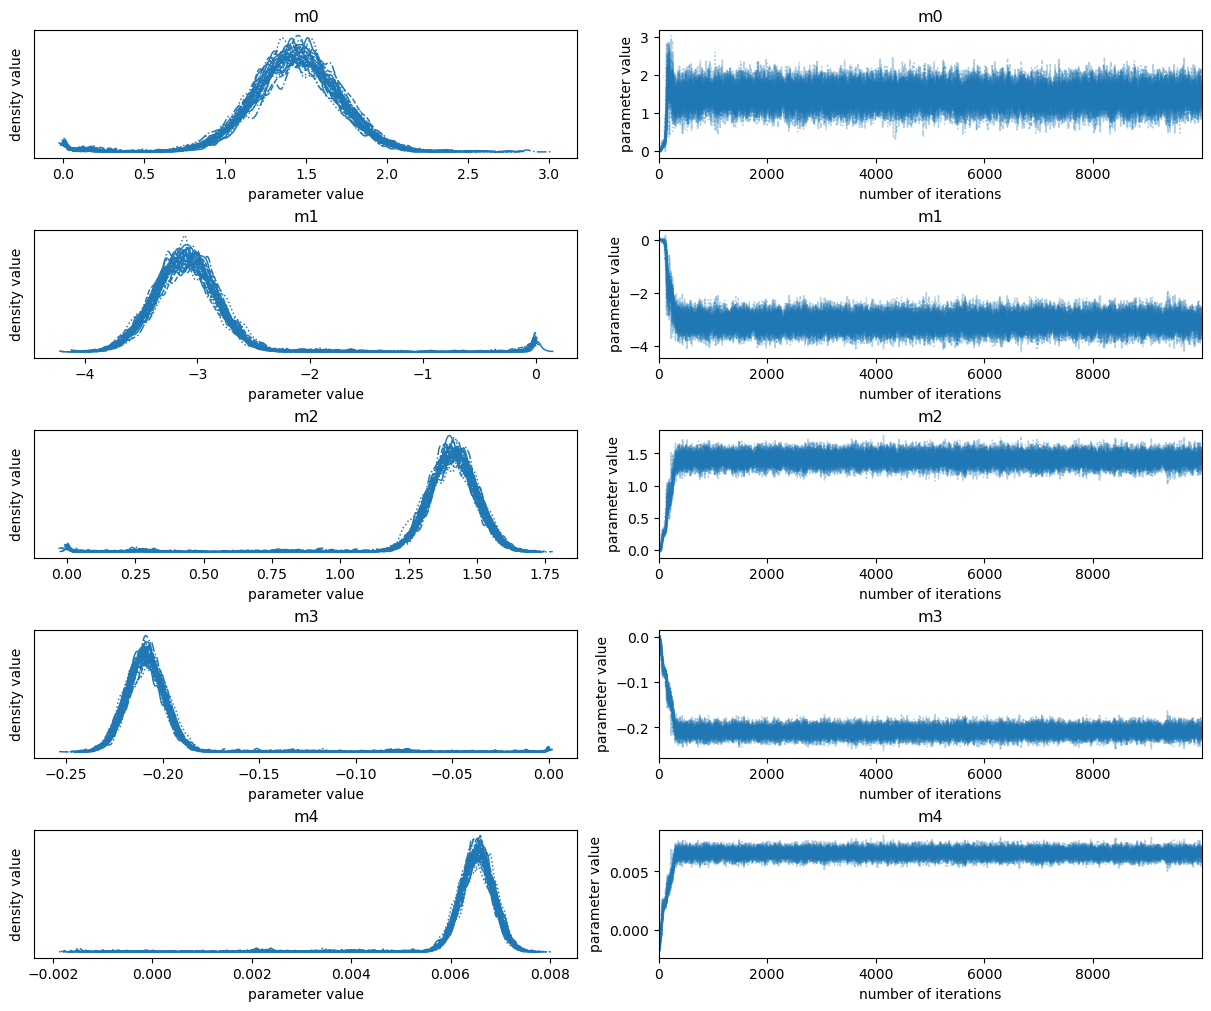

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

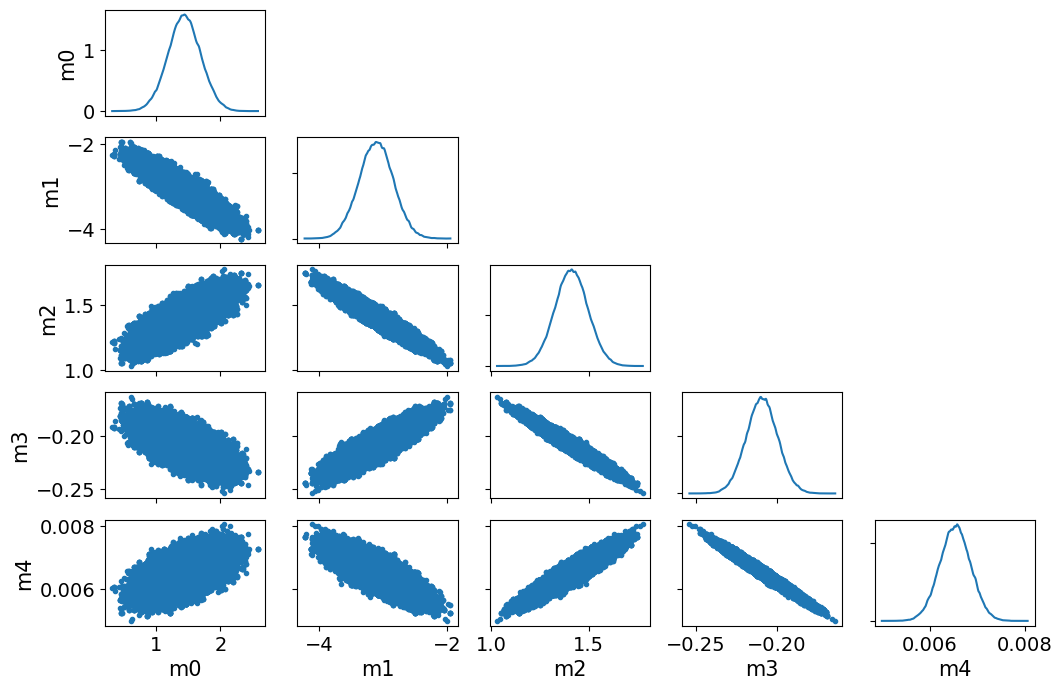

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

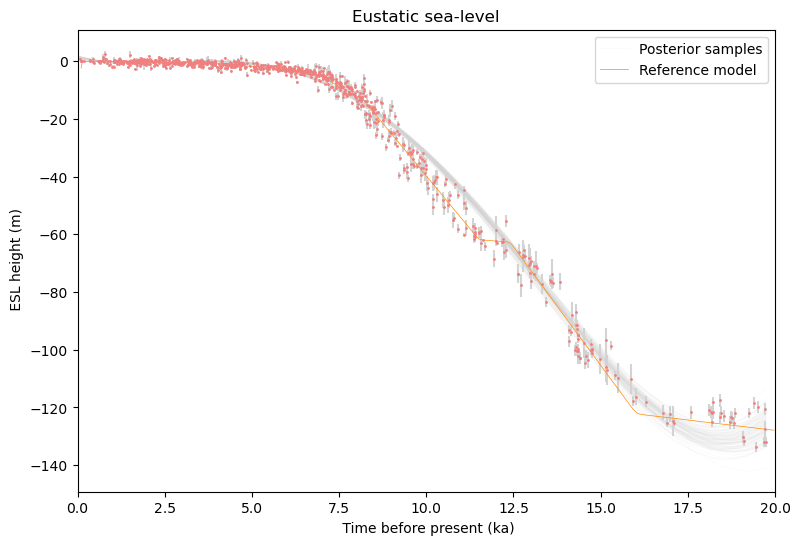

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.437 [  1.016,   1.861]
 m1  -3.111 [ -3.557,  -2.666]
 m2   1.413 [  1.273,   1.549]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.50119101e-02 -6.04096628e-02  1.59260404e-02 -1.51207622e-03
   4.43155852e-05]
 [-6.04096628e-02  7.16492066e-02 -2.14513446e-02  2.21285393e-03
  -6.82418850e-05]
 [ 1.59260404e-02 -2.14513446e-02  7.08347713e-03 -7.84556411e-04
   2.52553922e-05]
 [-1.51207622e-03  2.21285393e-03 -7.84556411e-04  9.19329421e-05
  -3.06584347e-06]
 [ 4.43155852e-05 -6.82418850e-05  2.52553922e-05 -3.06584347e-06
   1.05124749e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2550
    m1  0.2677
    m2  0.0842
    m3  0.0096
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                                            | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                 | 14/10000 [00:00<01:13, 136.44it/s]

  0%|▍                                                                                                                                                                 | 28/10000 [00:00<01:12, 137.17it/s]

  0%|▋                                                                                                                                                                 | 42/10000 [00:00<01:12, 137.61it/s]

  1%|▉                                                                                                                                                                 | 56/10000 [00:00<01:12, 137.99it/s]

  1%|█▏                                                                                                                                                                | 70/10000 [00:00<01:11, 138.11it/s]

  1%|█▎                                                                                                                                                                | 84/10000 [00:00<01:11, 138.22it/s]

  1%|█▌                                                                                                                                                                | 98/10000 [00:00<01:11, 138.45it/s]

  1%|█▊                                                                                                                                                               | 112/10000 [00:00<01:11, 138.55it/s]

  1%|██                                                                                                                                                               | 126/10000 [00:00<01:11, 138.66it/s]

  1%|██▎                                                                                                                                                              | 140/10000 [00:01<01:11, 138.69it/s]

  2%|██▍                                                                                                                                                              | 154/10000 [00:01<01:20, 123.01it/s]

  2%|██▋                                                                                                                                                              | 168/10000 [00:01<01:17, 126.74it/s]

  2%|██▉                                                                                                                                                              | 182/10000 [00:01<01:15, 130.16it/s]

  2%|███▏                                                                                                                                                             | 196/10000 [00:01<01:13, 132.72it/s]

  2%|███▍                                                                                                                                                             | 210/10000 [00:01<01:12, 134.54it/s]

  2%|███▌                                                                                                                                                             | 224/10000 [00:01<01:12, 135.75it/s]

  2%|███▊                                                                                                                                                             | 238/10000 [00:01<01:11, 136.73it/s]

  3%|████                                                                                                                                                             | 252/10000 [00:01<01:10, 137.48it/s]

  3%|████▎                                                                                                                                                            | 266/10000 [00:01<01:10, 137.94it/s]

  3%|████▌                                                                                                                                                            | 280/10000 [00:02<01:10, 137.18it/s]

  3%|████▋                                                                                                                                                            | 294/10000 [00:02<01:10, 137.43it/s]

  3%|████▉                                                                                                                                                            | 308/10000 [00:02<01:10, 138.08it/s]

  3%|█████▏                                                                                                                                                           | 323/10000 [00:02<01:09, 138.78it/s]

  3%|█████▍                                                                                                                                                           | 338/10000 [00:02<01:09, 139.25it/s]

  4%|█████▋                                                                                                                                                           | 353/10000 [00:02<01:09, 139.57it/s]

  4%|█████▉                                                                                                                                                           | 367/10000 [00:02<01:08, 139.69it/s]

  4%|██████▏                                                                                                                                                          | 382/10000 [00:02<01:08, 139.92it/s]

  4%|██████▍                                                                                                                                                          | 396/10000 [00:02<01:08, 139.94it/s]

  4%|██████▌                                                                                                                                                          | 411/10000 [00:03<01:08, 140.11it/s]

  4%|██████▊                                                                                                                                                          | 426/10000 [00:03<01:11, 134.64it/s]

  4%|███████                                                                                                                                                          | 441/10000 [00:03<01:10, 136.33it/s]

  5%|███████▎                                                                                                                                                         | 456/10000 [00:03<01:09, 137.47it/s]

  5%|███████▌                                                                                                                                                         | 471/10000 [00:03<01:08, 138.36it/s]

  5%|███████▊                                                                                                                                                         | 485/10000 [00:03<01:09, 136.26it/s]

  5%|████████                                                                                                                                                         | 499/10000 [00:03<01:09, 137.26it/s]

  5%|████████▎                                                                                                                                                        | 513/10000 [00:03<01:08, 137.77it/s]

  5%|████████▌                                                                                                                                                        | 528/10000 [00:03<01:08, 138.16it/s]

  5%|████████▋                                                                                                                                                        | 543/10000 [00:03<01:08, 138.80it/s]

  6%|████████▉                                                                                                                                                        | 558/10000 [00:04<01:07, 139.25it/s]

  6%|█████████▏                                                                                                                                                       | 572/10000 [00:04<01:07, 139.39it/s]

  6%|█████████▍                                                                                                                                                       | 587/10000 [00:04<01:07, 139.67it/s]

  6%|█████████▋                                                                                                                                                       | 601/10000 [00:04<01:07, 139.71it/s]

  6%|█████████▉                                                                                                                                                       | 616/10000 [00:04<01:07, 139.88it/s]

  6%|██████████▏                                                                                                                                                      | 631/10000 [00:04<01:06, 139.99it/s]

  6%|██████████▍                                                                                                                                                      | 646/10000 [00:04<01:06, 140.07it/s]

  7%|██████████▋                                                                                                                                                      | 661/10000 [00:04<01:06, 140.18it/s]

  7%|██████████▉                                                                                                                                                      | 676/10000 [00:04<01:06, 140.16it/s]

  7%|███████████▏                                                                                                                                                     | 691/10000 [00:05<01:06, 140.19it/s]

  7%|███████████▎                                                                                                                                                     | 706/10000 [00:05<01:15, 123.00it/s]

  7%|███████████▌                                                                                                                                                     | 720/10000 [00:05<01:12, 127.31it/s]

  7%|███████████▊                                                                                                                                                     | 735/10000 [00:05<01:10, 131.04it/s]

  8%|████████████                                                                                                                                                     | 750/10000 [00:05<01:09, 133.72it/s]

  8%|████████████▎                                                                                                                                                    | 764/10000 [00:05<01:08, 135.39it/s]

  8%|████████████▌                                                                                                                                                    | 778/10000 [00:05<01:07, 136.68it/s]

  8%|████████████▊                                                                                                                                                    | 793/10000 [00:05<01:06, 137.80it/s]

  8%|████████████▉                                                                                                                                                    | 807/10000 [00:05<01:07, 137.13it/s]

  8%|█████████████▏                                                                                                                                                   | 821/10000 [00:06<01:06, 137.92it/s]

  8%|█████████████▍                                                                                                                                                   | 835/10000 [00:06<01:06, 138.41it/s]

  8%|█████████████▋                                                                                                                                                   | 849/10000 [00:06<01:07, 135.68it/s]

  9%|█████████████▉                                                                                                                                                   | 864/10000 [00:06<01:06, 137.07it/s]

  9%|██████████████▏                                                                                                                                                  | 879/10000 [00:06<01:06, 138.09it/s]

  9%|██████████████▍                                                                                                                                                  | 894/10000 [00:06<01:05, 138.81it/s]

  9%|██████████████▋                                                                                                                                                  | 909/10000 [00:06<01:05, 139.25it/s]

  9%|██████████████▉                                                                                                                                                  | 924/10000 [00:06<01:05, 139.57it/s]

  9%|███████████████                                                                                                                                                  | 938/10000 [00:06<01:04, 139.65it/s]

 10%|███████████████▎                                                                                                                                                 | 953/10000 [00:06<01:04, 139.80it/s]

 10%|███████████████▌                                                                                                                                                 | 968/10000 [00:07<01:04, 139.97it/s]

 10%|███████████████▊                                                                                                                                                 | 982/10000 [00:07<01:04, 139.32it/s]

 10%|████████████████                                                                                                                                                 | 997/10000 [00:07<01:04, 139.63it/s]

 10%|████████████████▏                                                                                                                                               | 1012/10000 [00:07<01:04, 139.90it/s]

 10%|████████████████▍                                                                                                                                               | 1026/10000 [00:07<01:04, 139.90it/s]

 10%|████████████████▋                                                                                                                                               | 1040/10000 [00:07<01:04, 139.16it/s]

 11%|████████████████▊                                                                                                                                               | 1054/10000 [00:07<01:04, 139.39it/s]

 11%|█████████████████                                                                                                                                               | 1069/10000 [00:07<01:03, 139.77it/s]

 11%|█████████████████▎                                                                                                                                              | 1084/10000 [00:07<01:03, 139.97it/s]

 11%|█████████████████▌                                                                                                                                              | 1099/10000 [00:07<01:03, 140.12it/s]

 11%|█████████████████▊                                                                                                                                              | 1114/10000 [00:08<01:03, 140.19it/s]

 11%|██████████████████                                                                                                                                              | 1129/10000 [00:08<01:03, 140.21it/s]

 11%|██████████████████▎                                                                                                                                             | 1144/10000 [00:08<01:03, 140.38it/s]

 12%|██████████████████▌                                                                                                                                             | 1159/10000 [00:08<01:02, 140.41it/s]

 12%|██████████████████▊                                                                                                                                             | 1174/10000 [00:08<01:02, 140.46it/s]

 12%|███████████████████                                                                                                                                             | 1189/10000 [00:08<01:02, 140.43it/s]

 12%|███████████████████▎                                                                                                                                            | 1204/10000 [00:08<01:02, 140.38it/s]

 12%|███████████████████▌                                                                                                                                            | 1219/10000 [00:08<01:02, 140.39it/s]

 12%|███████████████████▋                                                                                                                                            | 1234/10000 [00:08<01:02, 140.33it/s]

 12%|███████████████████▉                                                                                                                                            | 1249/10000 [00:09<01:02, 140.33it/s]

 13%|████████████████████▏                                                                                                                                           | 1264/10000 [00:09<01:02, 140.40it/s]

 13%|████████████████████▍                                                                                                                                           | 1279/10000 [00:09<01:02, 140.45it/s]

 13%|████████████████████▋                                                                                                                                           | 1294/10000 [00:09<01:01, 140.43it/s]

 13%|████████████████████▉                                                                                                                                           | 1309/10000 [00:09<01:01, 140.45it/s]

 13%|█████████████████████▏                                                                                                                                          | 1324/10000 [00:09<01:02, 137.74it/s]

 13%|█████████████████████▍                                                                                                                                          | 1338/10000 [00:09<01:02, 138.36it/s]

 14%|█████████████████████▋                                                                                                                                          | 1353/10000 [00:09<01:02, 138.99it/s]

 14%|█████████████████████▊                                                                                                                                          | 1367/10000 [00:09<01:01, 139.26it/s]

 14%|██████████████████████                                                                                                                                          | 1381/10000 [00:10<01:01, 139.38it/s]

 14%|██████████████████████▎                                                                                                                                         | 1396/10000 [00:10<01:01, 139.73it/s]

 14%|██████████████████████▌                                                                                                                                         | 1410/10000 [00:10<01:01, 139.62it/s]

 14%|██████████████████████▊                                                                                                                                         | 1425/10000 [00:10<01:01, 139.86it/s]

 14%|███████████████████████                                                                                                                                         | 1440/10000 [00:10<01:01, 140.04it/s]

 15%|███████████████████████▎                                                                                                                                        | 1455/10000 [00:10<01:01, 140.06it/s]

 15%|███████████████████████▌                                                                                                                                        | 1470/10000 [00:10<01:00, 140.14it/s]

 15%|███████████████████████▊                                                                                                                                        | 1485/10000 [00:10<01:00, 140.27it/s]

 15%|████████████████████████                                                                                                                                        | 1500/10000 [00:10<01:00, 140.35it/s]

 15%|████████████████████████▏                                                                                                                                       | 1515/10000 [00:10<01:00, 140.39it/s]

 15%|████████████████████████▍                                                                                                                                       | 1530/10000 [00:11<01:00, 140.41it/s]

 15%|████████████████████████▋                                                                                                                                       | 1545/10000 [00:11<01:00, 139.51it/s]

 16%|████████████████████████▉                                                                                                                                       | 1560/10000 [00:11<01:00, 139.80it/s]

 16%|█████████████████████████▏                                                                                                                                      | 1575/10000 [00:11<01:00, 140.01it/s]

 16%|█████████████████████████▍                                                                                                                                      | 1590/10000 [00:11<01:00, 140.11it/s]

 16%|█████████████████████████▋                                                                                                                                      | 1605/10000 [00:11<01:00, 139.87it/s]

 16%|█████████████████████████▉                                                                                                                                      | 1620/10000 [00:11<00:59, 140.05it/s]

 16%|██████████████████████████▏                                                                                                                                     | 1635/10000 [00:11<00:59, 140.10it/s]

 16%|██████████████████████████▍                                                                                                                                     | 1650/10000 [00:11<00:59, 140.17it/s]

 17%|██████████████████████████▋                                                                                                                                     | 1665/10000 [00:12<00:59, 140.25it/s]

 17%|██████████████████████████▉                                                                                                                                     | 1680/10000 [00:12<00:59, 140.32it/s]

 17%|███████████████████████████                                                                                                                                     | 1695/10000 [00:12<00:59, 140.40it/s]

 17%|███████████████████████████▎                                                                                                                                    | 1710/10000 [00:12<00:59, 140.40it/s]

 17%|███████████████████████████▌                                                                                                                                    | 1725/10000 [00:12<00:58, 140.39it/s]

 17%|███████████████████████████▊                                                                                                                                    | 1740/10000 [00:12<01:07, 122.11it/s]

 18%|████████████████████████████                                                                                                                                    | 1754/10000 [00:12<01:05, 126.66it/s]

 18%|████████████████████████████▎                                                                                                                                   | 1768/10000 [00:12<01:03, 130.09it/s]

 18%|████████████████████████████▌                                                                                                                                   | 1783/10000 [00:12<01:01, 133.07it/s]

 18%|████████████████████████████▊                                                                                                                                   | 1798/10000 [00:13<01:00, 135.20it/s]

 18%|█████████████████████████████                                                                                                                                   | 1813/10000 [00:13<00:59, 136.77it/s]

 18%|█████████████████████████████▏                                                                                                                                  | 1828/10000 [00:13<00:59, 137.89it/s]

 18%|█████████████████████████████▍                                                                                                                                  | 1842/10000 [00:13<00:58, 138.32it/s]

 19%|█████████████████████████████▋                                                                                                                                  | 1857/10000 [00:13<00:58, 138.91it/s]

 19%|█████████████████████████████▉                                                                                                                                  | 1872/10000 [00:13<00:58, 139.34it/s]

 19%|██████████████████████████████▏                                                                                                                                 | 1886/10000 [00:13<00:59, 137.03it/s]

 19%|██████████████████████████████▍                                                                                                                                 | 1900/10000 [00:13<01:05, 122.91it/s]

 19%|██████████████████████████████▌                                                                                                                                 | 1914/10000 [00:13<01:03, 127.43it/s]

 19%|██████████████████████████████▊                                                                                                                                 | 1929/10000 [00:14<01:01, 131.13it/s]

 19%|███████████████████████████████                                                                                                                                 | 1943/10000 [00:14<01:00, 133.51it/s]

 20%|███████████████████████████████▎                                                                                                                                | 1957/10000 [00:14<00:59, 135.35it/s]

 20%|███████████████████████████████▌                                                                                                                                | 1971/10000 [00:14<00:58, 136.69it/s]

 20%|███████████████████████████████▊                                                                                                                                | 1986/10000 [00:14<00:58, 137.76it/s]

 20%|████████████████████████████████                                                                                                                                | 2001/10000 [00:14<00:57, 138.48it/s]

 20%|████████████████████████████████▏                                                                                                                               | 2015/10000 [00:14<00:57, 138.89it/s]

 20%|████████████████████████████████▍                                                                                                                               | 2029/10000 [00:14<00:57, 139.01it/s]

 20%|████████████████████████████████▋                                                                                                                               | 2043/10000 [00:14<00:57, 139.25it/s]

 21%|████████████████████████████████▉                                                                                                                               | 2057/10000 [00:14<00:56, 139.43it/s]

 21%|█████████████████████████████████▏                                                                                                                              | 2072/10000 [00:15<00:56, 139.67it/s]

 21%|█████████████████████████████████▍                                                                                                                              | 2087/10000 [00:15<00:56, 139.94it/s]

 21%|█████████████████████████████████▌                                                                                                                              | 2101/10000 [00:15<01:02, 125.90it/s]

 21%|█████████████████████████████████▊                                                                                                                              | 2115/10000 [00:15<01:00, 129.71it/s]

 21%|██████████████████████████████████                                                                                                                              | 2130/10000 [00:15<00:59, 132.88it/s]

 21%|██████████████████████████████████▎                                                                                                                             | 2144/10000 [00:15<00:58, 134.88it/s]

 22%|██████████████████████████████████▌                                                                                                                             | 2158/10000 [00:15<00:57, 136.33it/s]

 22%|██████████████████████████████████▊                                                                                                                             | 2173/10000 [00:15<00:56, 137.61it/s]

 22%|██████████████████████████████████▉                                                                                                                             | 2187/10000 [00:15<00:56, 137.40it/s]

 22%|███████████████████████████████████▏                                                                                                                            | 2202/10000 [00:16<00:56, 138.33it/s]

 22%|███████████████████████████████████▍                                                                                                                            | 2217/10000 [00:16<00:56, 138.96it/s]

 22%|███████████████████████████████████▋                                                                                                                            | 2231/10000 [00:16<00:59, 130.09it/s]

 22%|███████████████████████████████████▉                                                                                                                            | 2245/10000 [00:16<01:02, 123.52it/s]

 23%|████████████████████████████████████▏                                                                                                                           | 2259/10000 [00:16<01:00, 127.89it/s]

 23%|████████████████████████████████████▍                                                                                                                           | 2274/10000 [00:16<00:58, 131.55it/s]

 23%|████████████████████████████████████▌                                                                                                                           | 2288/10000 [00:16<00:57, 133.79it/s]

 23%|████████████████████████████████████▊                                                                                                                           | 2303/10000 [00:16<00:56, 135.74it/s]

 23%|█████████████████████████████████████                                                                                                                           | 2317/10000 [00:16<00:56, 136.95it/s]

 23%|█████████████████████████████████████▎                                                                                                                          | 2332/10000 [00:16<00:55, 138.01it/s]

 23%|█████████████████████████████████████▌                                                                                                                          | 2347/10000 [00:17<00:55, 138.72it/s]

 24%|█████████████████████████████████████▊                                                                                                                          | 2362/10000 [00:17<00:54, 139.27it/s]

 24%|██████████████████████████████████████                                                                                                                          | 2376/10000 [00:17<00:55, 138.17it/s]

 24%|██████████████████████████████████████▎                                                                                                                         | 2391/10000 [00:17<00:54, 138.89it/s]

 24%|██████████████████████████████████████▍                                                                                                                         | 2406/10000 [00:17<00:54, 139.38it/s]

 24%|██████████████████████████████████████▋                                                                                                                         | 2420/10000 [00:17<00:54, 138.77it/s]

 24%|██████████████████████████████████████▉                                                                                                                         | 2435/10000 [00:17<00:54, 139.34it/s]

 24%|███████████████████████████████████████▏                                                                                                                        | 2450/10000 [00:17<00:54, 139.60it/s]

 25%|███████████████████████████████████████▍                                                                                                                        | 2465/10000 [00:17<00:53, 139.89it/s]

 25%|███████████████████████████████████████▋                                                                                                                        | 2480/10000 [00:18<00:53, 140.02it/s]

 25%|███████████████████████████████████████▉                                                                                                                        | 2495/10000 [00:18<00:53, 140.12it/s]

 25%|████████████████████████████████████████▏                                                                                                                       | 2510/10000 [00:18<00:53, 140.26it/s]

 25%|████████████████████████████████████████▍                                                                                                                       | 2525/10000 [00:18<00:59, 126.66it/s]

 25%|████████████████████████████████████████▋                                                                                                                       | 2540/10000 [00:18<00:57, 130.45it/s]

 26%|████████████████████████████████████████▉                                                                                                                       | 2555/10000 [00:18<00:55, 133.28it/s]

 26%|█████████████████████████████████████████                                                                                                                       | 2570/10000 [00:18<00:54, 135.38it/s]

 26%|█████████████████████████████████████████▎                                                                                                                      | 2584/10000 [00:18<00:54, 136.42it/s]

 26%|█████████████████████████████████████████▌                                                                                                                      | 2598/10000 [00:18<00:53, 137.42it/s]

 26%|█████████████████████████████████████████▊                                                                                                                      | 2613/10000 [00:19<00:53, 138.34it/s]

 26%|██████████████████████████████████████████                                                                                                                      | 2627/10000 [00:19<00:53, 138.59it/s]

 26%|██████████████████████████████████████████▎                                                                                                                     | 2642/10000 [00:19<00:52, 139.06it/s]

 27%|██████████████████████████████████████████▍                                                                                                                     | 2656/10000 [00:19<00:53, 137.97it/s]

 27%|██████████████████████████████████████████▋                                                                                                                     | 2671/10000 [00:19<00:52, 138.67it/s]

 27%|██████████████████████████████████████████▉                                                                                                                     | 2686/10000 [00:19<00:52, 139.23it/s]

 27%|███████████████████████████████████████████▏                                                                                                                    | 2701/10000 [00:19<00:52, 139.50it/s]

 27%|███████████████████████████████████████████▍                                                                                                                    | 2715/10000 [00:19<00:52, 139.65it/s]

 27%|███████████████████████████████████████████▋                                                                                                                    | 2730/10000 [00:19<00:51, 139.93it/s]

 27%|███████████████████████████████████████████▉                                                                                                                    | 2745/10000 [00:19<00:51, 140.02it/s]

 28%|████████████████████████████████████████████▏                                                                                                                   | 2760/10000 [00:20<00:51, 140.09it/s]

 28%|████████████████████████████████████████████▍                                                                                                                   | 2775/10000 [00:20<00:51, 140.15it/s]

 28%|████████████████████████████████████████████▋                                                                                                                   | 2790/10000 [00:20<00:51, 140.03it/s]

 28%|████████████████████████████████████████████▉                                                                                                                   | 2805/10000 [00:20<00:51, 140.13it/s]

 28%|█████████████████████████████████████████████                                                                                                                   | 2820/10000 [00:20<00:52, 136.92it/s]

 28%|█████████████████████████████████████████████▎                                                                                                                  | 2835/10000 [00:20<00:51, 137.90it/s]

 28%|█████████████████████████████████████████████▌                                                                                                                  | 2850/10000 [00:20<00:51, 138.61it/s]

 29%|█████████████████████████████████████████████▊                                                                                                                  | 2865/10000 [00:20<00:51, 139.19it/s]

 29%|██████████████████████████████████████████████                                                                                                                  | 2879/10000 [00:20<00:52, 136.08it/s]

 29%|██████████████████████████████████████████████▎                                                                                                                 | 2894/10000 [00:21<00:51, 137.39it/s]

 29%|██████████████████████████████████████████████▌                                                                                                                 | 2908/10000 [00:21<00:51, 137.30it/s]

 29%|██████████████████████████████████████████████▊                                                                                                                 | 2923/10000 [00:21<00:51, 138.25it/s]

 29%|███████████████████████████████████████████████                                                                                                                 | 2938/10000 [00:21<00:50, 138.89it/s]

 30%|███████████████████████████████████████████████▏                                                                                                                | 2953/10000 [00:21<00:50, 139.38it/s]

 30%|███████████████████████████████████████████████▍                                                                                                                | 2968/10000 [00:21<00:50, 139.69it/s]

 30%|███████████████████████████████████████████████▋                                                                                                                | 2983/10000 [00:21<00:50, 139.95it/s]

 30%|███████████████████████████████████████████████▉                                                                                                                | 2998/10000 [00:21<00:49, 140.15it/s]

 30%|████████████████████████████████████████████████▏                                                                                                               | 3013/10000 [00:21<00:57, 122.57it/s]

 30%|████████████████████████████████████████████████▍                                                                                                               | 3027/10000 [00:22<00:54, 127.06it/s]

 30%|████████████████████████████████████████████████▋                                                                                                               | 3042/10000 [00:22<00:53, 130.80it/s]

 31%|████████████████████████████████████████████████▉                                                                                                               | 3057/10000 [00:22<00:52, 133.51it/s]

 31%|█████████████████████████████████████████████████▏                                                                                                              | 3072/10000 [00:22<00:51, 135.57it/s]

 31%|█████████████████████████████████████████████████▍                                                                                                              | 3087/10000 [00:22<00:50, 137.01it/s]

 31%|█████████████████████████████████████████████████▋                                                                                                              | 3102/10000 [00:22<00:49, 137.98it/s]

 31%|█████████████████████████████████████████████████▊                                                                                                              | 3116/10000 [00:22<00:49, 138.51it/s]

 31%|██████████████████████████████████████████████████                                                                                                              | 3130/10000 [00:22<00:49, 138.51it/s]

 31%|██████████████████████████████████████████████████▎                                                                                                             | 3145/10000 [00:22<00:49, 139.14it/s]

 32%|██████████████████████████████████████████████████▌                                                                                                             | 3159/10000 [00:23<00:49, 138.26it/s]

 32%|██████████████████████████████████████████████████▊                                                                                                             | 3174/10000 [00:23<00:49, 138.98it/s]

 32%|███████████████████████████████████████████████████                                                                                                             | 3189/10000 [00:23<00:48, 139.41it/s]

 32%|███████████████████████████████████████████████████▎                                                                                                            | 3204/10000 [00:23<00:48, 139.83it/s]

 32%|███████████████████████████████████████████████████▌                                                                                                            | 3219/10000 [00:23<00:48, 140.02it/s]

 32%|███████████████████████████████████████████████████▋                                                                                                            | 3234/10000 [00:23<00:48, 140.13it/s]

 32%|███████████████████████████████████████████████████▉                                                                                                            | 3249/10000 [00:23<00:48, 140.20it/s]

 33%|████████████████████████████████████████████████████▏                                                                                                           | 3264/10000 [00:23<00:48, 140.27it/s]

 33%|████████████████████████████████████████████████████▍                                                                                                           | 3279/10000 [00:23<00:47, 140.38it/s]

 33%|████████████████████████████████████████████████████▋                                                                                                           | 3294/10000 [00:23<00:47, 140.43it/s]

 33%|████████████████████████████████████████████████████▉                                                                                                           | 3309/10000 [00:24<00:47, 140.52it/s]

 33%|█████████████████████████████████████████████████████▏                                                                                                          | 3324/10000 [00:24<00:47, 140.52it/s]

 33%|█████████████████████████████████████████████████████▍                                                                                                          | 3339/10000 [00:24<00:47, 140.51it/s]

 34%|█████████████████████████████████████████████████████▋                                                                                                          | 3354/10000 [00:24<00:53, 124.04it/s]

 34%|█████████████████████████████████████████████████████▉                                                                                                          | 3368/10000 [00:24<00:51, 128.10it/s]

 34%|██████████████████████████████████████████████████████▏                                                                                                         | 3383/10000 [00:24<00:50, 131.53it/s]

 34%|██████████████████████████████████████████████████████▎                                                                                                         | 3398/10000 [00:24<00:49, 134.09it/s]

 34%|██████████████████████████████████████████████████████▌                                                                                                         | 3413/10000 [00:24<00:48, 135.97it/s]

 34%|██████████████████████████████████████████████████████▊                                                                                                         | 3427/10000 [00:24<00:47, 136.96it/s]

 34%|███████████████████████████████████████████████████████                                                                                                         | 3441/10000 [00:25<00:47, 137.66it/s]

 35%|███████████████████████████████████████████████████████▎                                                                                                        | 3456/10000 [00:25<00:47, 138.54it/s]

 35%|███████████████████████████████████████████████████████▌                                                                                                        | 3471/10000 [00:25<00:46, 139.13it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                        | 3485/10000 [00:25<00:47, 138.09it/s]

 35%|████████████████████████████████████████████████████████                                                                                                        | 3500/10000 [00:25<00:46, 138.74it/s]

 35%|████████████████████████████████████████████████████████▏                                                                                                       | 3515/10000 [00:25<00:46, 139.25it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                       | 3530/10000 [00:25<00:46, 139.53it/s]

 35%|████████████████████████████████████████████████████████▋                                                                                                       | 3545/10000 [00:25<00:46, 139.88it/s]

 36%|████████████████████████████████████████████████████████▉                                                                                                       | 3560/10000 [00:25<00:45, 140.09it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                      | 3575/10000 [00:26<00:45, 140.23it/s]

 36%|█████████████████████████████████████████████████████████▍                                                                                                      | 3590/10000 [00:26<00:45, 140.29it/s]

 36%|█████████████████████████████████████████████████████████▋                                                                                                      | 3605/10000 [00:26<00:45, 139.02it/s]

 36%|█████████████████████████████████████████████████████████▉                                                                                                      | 3619/10000 [00:26<00:45, 139.29it/s]

 36%|██████████████████████████████████████████████████████████▏                                                                                                     | 3634/10000 [00:26<00:45, 139.67it/s]

 36%|██████████████████████████████████████████████████████████▎                                                                                                     | 3648/10000 [00:26<00:46, 137.12it/s]

 37%|██████████████████████████████████████████████████████████▌                                                                                                     | 3662/10000 [00:26<00:45, 137.94it/s]

 37%|██████████████████████████████████████████████████████████▊                                                                                                     | 3676/10000 [00:26<00:45, 138.53it/s]

 37%|███████████████████████████████████████████████████████████                                                                                                     | 3691/10000 [00:26<00:45, 139.08it/s]

 37%|███████████████████████████████████████████████████████████▎                                                                                                    | 3706/10000 [00:26<00:45, 139.55it/s]

 37%|███████████████████████████████████████████████████████████▌                                                                                                    | 3721/10000 [00:27<00:44, 139.87it/s]

 37%|███████████████████████████████████████████████████████████▊                                                                                                    | 3736/10000 [00:27<00:44, 140.08it/s]

 38%|████████████████████████████████████████████████████████████                                                                                                    | 3751/10000 [00:27<00:44, 140.21it/s]

 38%|████████████████████████████████████████████████████████████▎                                                                                                   | 3766/10000 [00:27<00:44, 140.30it/s]

 38%|████████████████████████████████████████████████████████████▍                                                                                                   | 3781/10000 [00:27<00:46, 132.54it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                   | 3795/10000 [00:27<00:49, 124.79it/s]

 38%|████████████████████████████████████████████████████████████▉                                                                                                   | 3810/10000 [00:27<00:47, 129.16it/s]

 38%|█████████████████████████████████████████████████████████████▏                                                                                                  | 3824/10000 [00:27<00:46, 132.07it/s]

 38%|█████████████████████████████████████████████████████████████▍                                                                                                  | 3839/10000 [00:27<00:45, 134.47it/s]

 39%|█████████████████████████████████████████████████████████████▋                                                                                                  | 3853/10000 [00:28<00:45, 133.70it/s]

 39%|█████████████████████████████████████████████████████████████▉                                                                                                  | 3868/10000 [00:28<00:45, 135.66it/s]

 39%|██████████████████████████████████████████████████████████████▏                                                                                                 | 3883/10000 [00:28<00:44, 137.07it/s]

 39%|██████████████████████████████████████████████████████████████▎                                                                                                 | 3898/10000 [00:28<00:44, 138.13it/s]

 39%|██████████████████████████████████████████████████████████████▌                                                                                                 | 3913/10000 [00:28<00:43, 138.85it/s]

 39%|██████████████████████████████████████████████████████████████▊                                                                                                 | 3927/10000 [00:28<00:43, 138.08it/s]

 39%|███████████████████████████████████████████████████████████████                                                                                                 | 3942/10000 [00:28<00:43, 138.73it/s]

 40%|███████████████████████████████████████████████████████████████▎                                                                                                | 3956/10000 [00:28<00:44, 136.55it/s]

 40%|███████████████████████████████████████████████████████████████▌                                                                                                | 3971/10000 [00:28<00:43, 137.69it/s]

 40%|███████████████████████████████████████████████████████████████▊                                                                                                | 3986/10000 [00:29<00:43, 138.52it/s]

 40%|████████████████████████████████████████████████████████████████                                                                                                | 4001/10000 [00:29<00:43, 139.10it/s]

 40%|████████████████████████████████████████████████████████████████▏                                                                                               | 4015/10000 [00:29<00:42, 139.32it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                               | 4030/10000 [00:29<00:42, 139.72it/s]

 40%|████████████████████████████████████████████████████████████████▋                                                                                               | 4044/10000 [00:29<00:43, 137.51it/s]

 41%|████████████████████████████████████████████████████████████████▉                                                                                               | 4059/10000 [00:29<00:42, 138.37it/s]

 41%|█████████████████████████████████████████████████████████████████▏                                                                                              | 4074/10000 [00:29<00:42, 139.01it/s]

 41%|█████████████████████████████████████████████████████████████████▍                                                                                              | 4089/10000 [00:29<00:42, 139.46it/s]

 41%|█████████████████████████████████████████████████████████████████▋                                                                                              | 4104/10000 [00:29<00:42, 139.82it/s]

 41%|█████████████████████████████████████████████████████████████████▉                                                                                              | 4118/10000 [00:29<00:42, 139.64it/s]

 41%|██████████████████████████████████████████████████████████████████                                                                                              | 4132/10000 [00:30<00:54, 107.59it/s]

 41%|██████████████████████████████████████████████████████████████████▎                                                                                             | 4146/10000 [00:30<00:51, 114.68it/s]

 42%|██████████████████████████████████████████████████████████████████▌                                                                                             | 4160/10000 [00:30<00:48, 120.90it/s]

 42%|██████████████████████████████████████████████████████████████████▊                                                                                             | 4174/10000 [00:30<00:46, 125.73it/s]

 42%|███████████████████████████████████████████████████████████████████                                                                                             | 4188/10000 [00:30<00:45, 128.14it/s]

 42%|███████████████████████████████████████████████████████████████████▏                                                                                            | 4202/10000 [00:30<00:46, 123.86it/s]

 42%|███████████████████████████████████████████████████████████████████▍                                                                                            | 4216/10000 [00:30<00:45, 127.95it/s]

 42%|███████████████████████████████████████████████████████████████████▋                                                                                            | 4230/10000 [00:30<00:43, 131.14it/s]

 42%|███████████████████████████████████████████████████████████████████▉                                                                                            | 4244/10000 [00:31<00:43, 133.43it/s]

 43%|████████████████████████████████████████████████████████████████████▏                                                                                           | 4258/10000 [00:31<00:42, 135.06it/s]

 43%|████████████████████████████████████████████████████████████████████▎                                                                                           | 4272/10000 [00:31<00:51, 111.53it/s]

 43%|████████████████████████████████████████████████████████████████████▌                                                                                           | 4285/10000 [00:31<00:49, 115.73it/s]

 43%|████████████████████████████████████████████████████████████████████▊                                                                                           | 4299/10000 [00:31<00:46, 121.88it/s]

 43%|█████████████████████████████████████████████████████████████████████                                                                                           | 4313/10000 [00:31<00:44, 126.60it/s]

 43%|█████████████████████████████████████████████████████████████████████▏                                                                                          | 4327/10000 [00:31<00:44, 127.09it/s]

 43%|█████████████████████████████████████████████████████████████████████▍                                                                                          | 4341/10000 [00:31<00:43, 130.26it/s]

 44%|█████████████████████████████████████████████████████████████████████▋                                                                                          | 4355/10000 [00:31<00:42, 132.79it/s]

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                          | 4369/10000 [00:32<00:41, 134.64it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                         | 4383/10000 [00:32<00:41, 135.62it/s]

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                         | 4397/10000 [00:32<00:41, 136.63it/s]

 44%|██████████████████████████████████████████████████████████████████████▌                                                                                         | 4411/10000 [00:32<00:40, 137.37it/s]

 44%|██████████████████████████████████████████████████████████████████████▊                                                                                         | 4425/10000 [00:32<00:40, 137.88it/s]

 44%|███████████████████████████████████████████████████████████████████████                                                                                         | 4439/10000 [00:32<00:40, 138.23it/s]

 45%|███████████████████████████████████████████████████████████████████████▏                                                                                        | 4453/10000 [00:32<00:42, 129.77it/s]

 45%|███████████████████████████████████████████████████████████████████████▍                                                                                        | 4467/10000 [00:32<00:45, 122.89it/s]

 45%|███████████████████████████████████████████████████████████████████████▋                                                                                        | 4481/10000 [00:32<00:43, 127.14it/s]

 45%|███████████████████████████████████████████████████████████████████████▉                                                                                        | 4494/10000 [00:32<00:43, 127.66it/s]

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                       | 4508/10000 [00:33<00:41, 130.89it/s]

 45%|████████████████████████████████████████████████████████████████████████▎                                                                                       | 4522/10000 [00:33<00:41, 130.93it/s]

 45%|████████████████████████████████████████████████████████████████████████▌                                                                                       | 4536/10000 [00:33<00:43, 125.71it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                       | 4550/10000 [00:33<00:42, 129.43it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                       | 4564/10000 [00:33<00:41, 132.18it/s]

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                      | 4578/10000 [00:33<00:40, 134.03it/s]

 46%|█████████████████████████████████████████████████████████████████████████▍                                                                                      | 4592/10000 [00:33<00:41, 131.38it/s]

 46%|█████████████████████████████████████████████████████████████████████████▋                                                                                      | 4606/10000 [00:33<00:44, 121.07it/s]

 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                      | 4620/10000 [00:33<00:42, 126.00it/s]

 46%|██████████████████████████████████████████████████████████████████████████▏                                                                                     | 4634/10000 [00:34<00:42, 127.71it/s]

 46%|██████████████████████████████████████████████████████████████████████████▎                                                                                     | 4648/10000 [00:34<00:41, 129.87it/s]

 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                     | 4662/10000 [00:34<00:40, 132.51it/s]

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                     | 4676/10000 [00:34<00:39, 133.80it/s]

 47%|███████████████████████████████████████████████████████████████████████████                                                                                     | 4690/10000 [00:34<00:39, 135.13it/s]

 47%|███████████████████████████████████████████████████████████████████████████▎                                                                                    | 4704/10000 [00:34<00:38, 136.24it/s]

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                    | 4718/10000 [00:34<00:38, 136.83it/s]

 47%|███████████████████████████████████████████████████████████████████████████▋                                                                                    | 4732/10000 [00:34<00:38, 137.52it/s]

 47%|███████████████████████████████████████████████████████████████████████████▉                                                                                    | 4746/10000 [00:34<00:38, 138.04it/s]

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                   | 4760/10000 [00:34<00:37, 138.46it/s]

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                   | 4774/10000 [00:35<00:37, 138.41it/s]

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                   | 4788/10000 [00:35<00:38, 135.56it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                   | 4802/10000 [00:35<00:38, 136.68it/s]

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                   | 4816/10000 [00:35<00:38, 134.91it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▎                                                                                  | 4830/10000 [00:35<00:37, 136.18it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▌                                                                                  | 4844/10000 [00:35<00:37, 137.07it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                  | 4858/10000 [00:35<00:38, 135.02it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▉                                                                                  | 4872/10000 [00:35<00:37, 136.26it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                 | 4886/10000 [00:35<00:37, 137.21it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                 | 4900/10000 [00:35<00:36, 137.87it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                 | 4914/10000 [00:36<00:36, 138.36it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▊                                                                                 | 4928/10000 [00:36<00:36, 137.52it/s]

 49%|███████████████████████████████████████████████████████████████████████████████                                                                                 | 4942/10000 [00:36<00:36, 138.04it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                                | 4956/10000 [00:36<00:36, 138.46it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                                | 4970/10000 [00:36<00:36, 138.72it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                                | 4984/10000 [00:36<00:36, 138.15it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▉                                                                                | 4998/10000 [00:36<00:41, 120.71it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                               | 5012/10000 [00:36<00:39, 125.58it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▍                                                                               | 5026/10000 [00:36<00:38, 129.39it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▋                                                                               | 5040/10000 [00:37<00:37, 131.94it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                               | 5054/10000 [00:37<00:36, 134.06it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████                                                                               | 5068/10000 [00:37<00:36, 135.59it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                              | 5082/10000 [00:37<00:36, 136.56it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                              | 5096/10000 [00:37<00:35, 137.43it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▊                                                                              | 5110/10000 [00:37<00:35, 137.16it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▉                                                                              | 5124/10000 [00:37<00:36, 135.43it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▏                                                                             | 5138/10000 [00:37<00:35, 135.23it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                             | 5152/10000 [00:37<00:35, 136.42it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                             | 5166/10000 [00:37<00:35, 137.29it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                             | 5180/10000 [00:38<00:34, 137.96it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████                                                                             | 5194/10000 [00:38<00:34, 138.38it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▎                                                                            | 5209/10000 [00:38<00:34, 138.91it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5223/10000 [00:38<00:34, 139.21it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5238/10000 [00:38<00:34, 139.56it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████                                                                            | 5252/10000 [00:38<00:34, 139.58it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5266/10000 [00:38<00:33, 139.62it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5280/10000 [00:38<00:33, 139.70it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5295/10000 [00:38<00:33, 139.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5309/10000 [00:38<00:33, 139.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5324/10000 [00:39<00:33, 139.98it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5338/10000 [00:39<00:33, 139.92it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5352/10000 [00:39<00:33, 139.80it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5367/10000 [00:39<00:33, 139.91it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                          | 5382/10000 [00:39<00:32, 139.98it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5396/10000 [00:39<00:32, 139.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5410/10000 [00:39<00:32, 139.79it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5425/10000 [00:39<00:32, 139.88it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████                                                                         | 5439/10000 [00:39<00:32, 139.64it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5454/10000 [00:40<00:32, 139.78it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5468/10000 [00:40<00:32, 139.84it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5482/10000 [00:40<00:32, 139.47it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5497/10000 [00:40<00:32, 139.68it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5512/10000 [00:40<00:32, 139.86it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5526/10000 [00:40<00:32, 139.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5541/10000 [00:40<00:31, 139.78it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5555/10000 [00:40<00:31, 139.74it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                       | 5570/10000 [00:40<00:31, 139.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5584/10000 [00:40<00:31, 139.89it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5598/10000 [00:41<00:31, 139.60it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5612/10000 [00:41<00:32, 135.52it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████                                                                      | 5626/10000 [00:41<00:31, 136.79it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5640/10000 [00:41<00:31, 137.68it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5655/10000 [00:41<00:31, 138.48it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5669/10000 [00:41<00:31, 138.85it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5684/10000 [00:41<00:30, 139.27it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5699/10000 [00:41<00:30, 139.56it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5714/10000 [00:41<00:30, 139.77it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5728/10000 [00:41<00:30, 139.62it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5742/10000 [00:42<00:34, 122.33it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5756/10000 [00:42<00:33, 126.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5770/10000 [00:42<00:32, 130.40it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5784/10000 [00:42<00:31, 132.99it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5799/10000 [00:42<00:31, 135.19it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5813/10000 [00:42<00:31, 132.96it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5827/10000 [00:42<00:30, 134.88it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5842/10000 [00:42<00:30, 136.51it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5857/10000 [00:42<00:30, 137.62it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5872/10000 [00:43<00:29, 138.43it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5886/10000 [00:43<00:29, 137.61it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5900/10000 [00:43<00:29, 138.28it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5915/10000 [00:43<00:29, 138.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5929/10000 [00:43<00:29, 139.21it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5944/10000 [00:43<00:29, 139.52it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5959/10000 [00:43<00:28, 139.77it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5974/10000 [00:43<00:28, 139.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5988/10000 [00:43<00:31, 127.51it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 6002/10000 [00:44<00:30, 130.80it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 6016/10000 [00:44<00:29, 133.37it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6030/10000 [00:44<00:29, 135.23it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 6045/10000 [00:44<00:28, 136.72it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 6060/10000 [00:44<00:28, 137.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 6075/10000 [00:44<00:28, 138.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 6089/10000 [00:44<00:28, 138.92it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 6104/10000 [00:44<00:27, 139.29it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 6118/10000 [00:44<00:31, 122.01it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6132/10000 [00:45<00:30, 126.61it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6146/10000 [00:45<00:29, 130.17it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 6160/10000 [00:45<00:28, 132.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 6174/10000 [00:45<00:28, 134.90it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 6189/10000 [00:45<00:27, 136.53it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 6203/10000 [00:45<00:27, 137.14it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 6217/10000 [00:45<00:27, 137.79it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6231/10000 [00:45<00:27, 138.29it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6245/10000 [00:45<00:27, 138.74it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6259/10000 [00:45<00:27, 137.39it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6273/10000 [00:46<00:26, 138.08it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6287/10000 [00:46<00:26, 138.60it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6301/10000 [00:46<00:26, 137.90it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6315/10000 [00:46<00:26, 138.44it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6330/10000 [00:46<00:26, 139.03it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6344/10000 [00:46<00:26, 139.28it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6358/10000 [00:46<00:26, 139.46it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6373/10000 [00:46<00:25, 139.68it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6388/10000 [00:46<00:25, 139.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6402/10000 [00:46<00:25, 139.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6416/10000 [00:47<00:25, 139.85it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6430/10000 [00:47<00:25, 139.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6445/10000 [00:47<00:25, 139.97it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6459/10000 [00:47<00:25, 139.97it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6474/10000 [00:47<00:25, 140.06it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6489/10000 [00:47<00:25, 139.20it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6504/10000 [00:47<00:25, 139.53it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6519/10000 [00:47<00:24, 139.71it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6533/10000 [00:47<00:24, 139.70it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6547/10000 [00:48<00:24, 139.70it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6561/10000 [00:48<00:25, 135.41it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6575/10000 [00:48<00:25, 136.47it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6590/10000 [00:48<00:24, 137.60it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6605/10000 [00:48<00:24, 138.39it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6619/10000 [00:48<00:24, 138.80it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6634/10000 [00:48<00:24, 139.22it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6648/10000 [00:48<00:24, 139.41it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6663/10000 [00:48<00:23, 139.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6678/10000 [00:48<00:23, 139.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6693/10000 [00:49<00:23, 139.98it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6707/10000 [00:49<00:23, 139.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6722/10000 [00:49<00:23, 139.91it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6736/10000 [00:49<00:23, 139.81it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6751/10000 [00:49<00:23, 139.93it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6766/10000 [00:49<00:23, 140.00it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6780/10000 [00:49<00:23, 139.58it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6794/10000 [00:49<00:22, 139.58it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6808/10000 [00:49<00:22, 139.67it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6822/10000 [00:49<00:22, 139.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6836/10000 [00:50<00:22, 139.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6850/10000 [00:50<00:22, 139.74it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6864/10000 [00:50<00:22, 139.57it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6879/10000 [00:50<00:22, 139.78it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6893/10000 [00:50<00:22, 139.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6908/10000 [00:50<00:22, 139.92it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6923/10000 [00:50<00:21, 140.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6938/10000 [00:50<00:21, 140.10it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6953/10000 [00:50<00:21, 140.01it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6968/10000 [00:51<00:21, 140.09it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6983/10000 [00:51<00:21, 140.07it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6998/10000 [00:51<00:21, 139.06it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 7012/10000 [00:51<00:21, 139.07it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 7026/10000 [00:51<00:21, 139.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 7040/10000 [00:51<00:21, 139.43it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 7054/10000 [00:51<00:21, 139.59it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 7068/10000 [00:51<00:20, 139.67it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7082/10000 [00:51<00:20, 139.75it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7096/10000 [00:51<00:20, 139.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7110/10000 [00:52<00:20, 139.79it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 7124/10000 [00:52<00:20, 139.85it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7138/10000 [00:52<00:20, 139.73it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7152/10000 [00:52<00:20, 139.78it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 7166/10000 [00:52<00:20, 139.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7180/10000 [00:52<00:20, 139.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 7194/10000 [00:52<00:20, 139.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7208/10000 [00:52<00:19, 139.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7223/10000 [00:52<00:19, 139.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7238/10000 [00:52<00:19, 139.99it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7253/10000 [00:53<00:19, 140.07it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7268/10000 [00:53<00:19, 140.15it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7283/10000 [00:53<00:19, 140.16it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7298/10000 [00:53<00:19, 140.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7313/10000 [00:53<00:19, 140.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7328/10000 [00:53<00:19, 140.21it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7343/10000 [00:53<00:19, 136.99it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7357/10000 [00:53<00:21, 125.28it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7371/10000 [00:53<00:20, 129.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7385/10000 [00:54<00:19, 132.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7399/10000 [00:54<00:19, 134.30it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7413/10000 [00:54<00:19, 135.94it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7428/10000 [00:54<00:18, 137.22it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7443/10000 [00:54<00:18, 138.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7458/10000 [00:54<00:18, 138.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7472/10000 [00:54<00:18, 139.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7487/10000 [00:54<00:18, 139.46it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7501/10000 [00:54<00:17, 139.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7515/10000 [00:54<00:17, 139.62it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7529/10000 [00:55<00:17, 139.71it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7544/10000 [00:55<00:17, 139.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7558/10000 [00:55<00:17, 139.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7572/10000 [00:55<00:17, 139.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7586/10000 [00:55<00:17, 139.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7600/10000 [00:55<00:17, 139.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7614/10000 [00:55<00:17, 139.49it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7628/10000 [00:55<00:16, 139.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7642/10000 [00:55<00:16, 139.70it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7656/10000 [00:55<00:16, 139.77it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7670/10000 [00:56<00:16, 139.78it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7684/10000 [00:56<00:16, 138.19it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7698/10000 [00:56<00:16, 138.67it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7712/10000 [00:56<00:16, 139.04it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7726/10000 [00:56<00:16, 139.32it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7740/10000 [00:56<00:16, 139.18it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7754/10000 [00:56<00:16, 139.33it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7769/10000 [00:56<00:15, 139.58it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7783/10000 [00:56<00:15, 139.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7798/10000 [00:57<00:15, 139.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7812/10000 [00:57<00:15, 139.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7826/10000 [00:57<00:15, 139.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7841/10000 [00:57<00:15, 139.74it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7855/10000 [00:57<00:15, 139.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7870/10000 [00:57<00:15, 139.92it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7884/10000 [00:57<00:15, 139.02it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7898/10000 [00:57<00:15, 139.09it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7912/10000 [00:57<00:15, 139.09it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7927/10000 [00:57<00:14, 139.40it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7941/10000 [00:58<00:15, 136.04it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7955/10000 [00:58<00:14, 137.17it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7969/10000 [00:58<00:14, 137.95it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7983/10000 [00:58<00:14, 138.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7998/10000 [00:58<00:14, 139.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8012/10000 [00:58<00:14, 139.28it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 8026/10000 [00:58<00:14, 139.37it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8041/10000 [00:58<00:14, 139.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8055/10000 [00:58<00:13, 139.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8070/10000 [00:58<00:13, 139.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8085/10000 [00:59<00:13, 140.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8100/10000 [00:59<00:13, 140.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8115/10000 [00:59<00:13, 140.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8130/10000 [00:59<00:15, 122.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8144/10000 [00:59<00:14, 127.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8158/10000 [00:59<00:14, 130.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8172/10000 [00:59<00:13, 132.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8186/10000 [01:00<00:20, 90.44it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8200/10000 [01:00<00:17, 100.48it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8214/10000 [01:00<00:16, 109.25it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8227/10000 [01:00<00:15, 113.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8245/10000 [01:00<00:13, 130.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8265/10000 [01:00<00:11, 149.21it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8285/10000 [01:00<00:10, 162.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8305/10000 [01:00<00:09, 171.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8325/10000 [01:00<00:09, 179.23it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8345/10000 [01:00<00:08, 184.48it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8365/10000 [01:01<00:08, 188.76it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8385/10000 [01:01<00:08, 191.36it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8405/10000 [01:01<00:08, 177.73it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8424/10000 [01:01<00:10, 148.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8440/10000 [01:01<00:12, 126.70it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8454/10000 [01:01<00:11, 129.58it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8468/10000 [01:01<00:11, 132.08it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8482/10000 [01:01<00:11, 134.07it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8496/10000 [01:02<00:11, 135.62it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8511/10000 [01:02<00:10, 136.98it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8525/10000 [01:02<00:10, 137.76it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8540/10000 [01:02<00:10, 138.49it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8554/10000 [01:02<00:10, 138.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8568/10000 [01:02<00:11, 126.78it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8582/10000 [01:02<00:10, 129.96it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8596/10000 [01:02<00:10, 132.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8610/10000 [01:02<00:10, 134.57it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8625/10000 [01:02<00:10, 136.27it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8639/10000 [01:03<00:09, 137.18it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8653/10000 [01:03<00:09, 137.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8667/10000 [01:03<00:09, 138.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8681/10000 [01:03<00:09, 138.60it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8695/10000 [01:03<00:09, 132.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8709/10000 [01:03<00:09, 133.17it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8723/10000 [01:03<00:09, 134.94it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8737/10000 [01:03<00:09, 136.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8751/10000 [01:03<00:09, 135.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8765/10000 [01:04<00:09, 136.17it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8779/10000 [01:04<00:08, 137.13it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8793/10000 [01:04<00:08, 137.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8807/10000 [01:04<00:08, 137.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8821/10000 [01:04<00:09, 121.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8835/10000 [01:04<00:09, 126.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8849/10000 [01:04<00:08, 130.05it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8863/10000 [01:04<00:08, 132.72it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8877/10000 [01:04<00:08, 134.69it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8891/10000 [01:04<00:08, 136.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8905/10000 [01:05<00:07, 137.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8919/10000 [01:05<00:07, 137.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8933/10000 [01:05<00:07, 138.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8947/10000 [01:05<00:07, 138.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8961/10000 [01:05<00:07, 137.33it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8975/10000 [01:05<00:07, 137.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8989/10000 [01:05<00:07, 138.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9003/10000 [01:05<00:07, 138.50it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9017/10000 [01:05<00:07, 138.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9031/10000 [01:05<00:06, 139.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9045/10000 [01:06<00:06, 139.00it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9059/10000 [01:06<00:06, 138.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9073/10000 [01:06<00:06, 138.36it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9087/10000 [01:06<00:06, 138.72it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9101/10000 [01:06<00:06, 138.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9115/10000 [01:06<00:06, 139.08it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9129/10000 [01:06<00:06, 139.15it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9143/10000 [01:06<00:06, 139.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9157/10000 [01:06<00:06, 139.28it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9171/10000 [01:06<00:05, 138.94it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9185/10000 [01:07<00:05, 138.64it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9199/10000 [01:07<00:05, 138.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9213/10000 [01:07<00:05, 138.34it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9227/10000 [01:07<00:05, 138.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9241/10000 [01:07<00:05, 138.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9255/10000 [01:07<00:05, 137.98it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9269/10000 [01:07<00:05, 138.31it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9283/10000 [01:07<00:05, 138.60it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9297/10000 [01:07<00:05, 138.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9311/10000 [01:07<00:04, 139.08it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9326/10000 [01:08<00:04, 139.41it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9341/10000 [01:08<00:04, 139.68it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9355/10000 [01:08<00:04, 139.65it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9370/10000 [01:08<00:04, 139.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9384/10000 [01:08<00:04, 139.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9399/10000 [01:08<00:04, 139.97it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9413/10000 [01:08<00:04, 139.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9427/10000 [01:08<00:04, 139.91it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9441/10000 [01:08<00:03, 139.90it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9456/10000 [01:09<00:03, 139.99it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9470/10000 [01:09<00:03, 139.92it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9484/10000 [01:09<00:03, 139.90it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9498/10000 [01:09<00:03, 131.01it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9512/10000 [01:09<00:04, 112.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9526/10000 [01:09<00:03, 119.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9540/10000 [01:09<00:03, 124.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9555/10000 [01:09<00:03, 128.89it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9569/10000 [01:09<00:03, 131.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9584/10000 [01:10<00:03, 134.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9598/10000 [01:10<00:02, 135.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9613/10000 [01:10<00:02, 137.15it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9627/10000 [01:10<00:02, 137.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9641/10000 [01:10<00:02, 136.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9655/10000 [01:10<00:02, 120.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9669/10000 [01:10<00:02, 125.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9684/10000 [01:10<00:02, 129.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9698/10000 [01:10<00:02, 132.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9713/10000 [01:11<00:02, 134.50it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9727/10000 [01:11<00:02, 135.98it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9741/10000 [01:11<00:01, 136.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9755/10000 [01:11<00:01, 137.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9770/10000 [01:11<00:01, 138.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9784/10000 [01:11<00:01, 137.26it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9798/10000 [01:11<00:01, 138.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9813/10000 [01:11<00:01, 138.72it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9827/10000 [01:11<00:01, 138.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9841/10000 [01:11<00:01, 138.91it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9855/10000 [01:12<00:01, 138.93it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9869/10000 [01:12<00:00, 138.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9883/10000 [01:12<00:00, 138.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9897/10000 [01:12<00:00, 138.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9911/10000 [01:12<00:00, 138.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9925/10000 [01:12<00:00, 138.93it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9939/10000 [01:12<00:00, 138.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9953/10000 [01:12<00:00, 138.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9967/10000 [01:12<00:00, 138.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9981/10000 [01:12<00:00, 138.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9995/10000 [01:13<00:00, 138.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.85it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


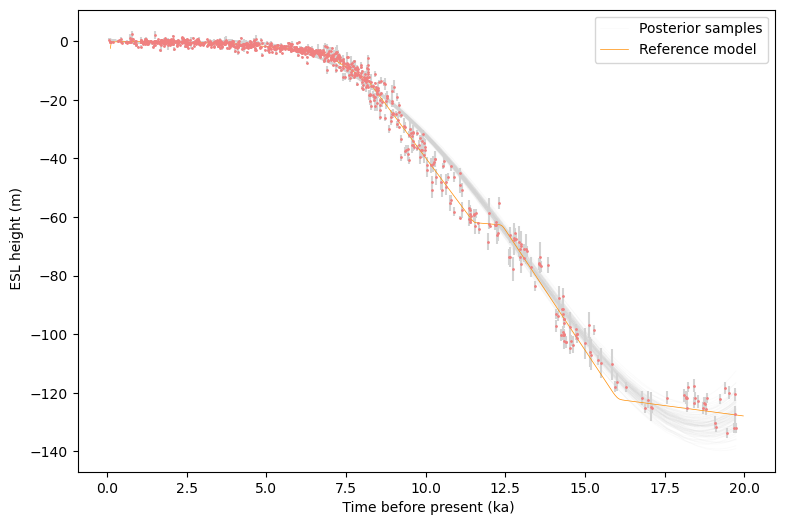

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev23
numpy 1.21.6
scipy 1.9.1
matplotlib 3.5.3
emcee 3.1.2
arviz 0.12.1
